<a href="https://colab.research.google.com/github/ostrichkim/colab/blob/main/assignment_resnet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 시작

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# copy folder
%cp -av /content/drive/MyDrive/대학원수업/[수업]딥러닝/kuaicv_assingment-main/models /content/
%cp -av /content/drive/MyDrive/대학원수업/[수업]딥러닝/kuaicv_assingment-main/utils.py /content/

'/content/drive/MyDrive/대학원수업/[수업]딥러닝/kuaicv_assingment-main/models' -> '/content/models'
'/content/drive/MyDrive/대학원수업/[수업]딥러닝/kuaicv_assingment-main/models/resnet.py' -> '/content/models/resnet.py'
'/content/drive/MyDrive/대학원수업/[수업]딥러닝/kuaicv_assingment-main/models/dla_simple.py' -> '/content/models/dla_simple.py'
'/content/drive/MyDrive/대학원수업/[수업]딥러닝/kuaicv_assingment-main/models/MobileNetV2.py' -> '/content/models/MobileNetV2.py'
'/content/drive/MyDrive/대학원수업/[수업]딥러닝/kuaicv_assingment-main/models/__init__.py' -> '/content/models/__init__.py'
'/content/drive/MyDrive/대학원수업/[수업]딥러닝/kuaicv_assingment-main/utils.py' -> '/content/utils.py'


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms

import os
import argparse
import random

from models import *

random.seed(1)

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch

In [14]:
img_size=150
learning_rate = 0.0001
epochs = 90
weight_decay = 5e-4
momentum = 0.9
batch_size = 16
num_workers = 2
num_classes = 20

In [15]:
# Normalize with mean and std
from torchvision.io import read_image
from torchvision import datasets

random.seed(1)
# trainset = datasets.ImageFolder('/content/drive/MyDrive/대학원수업/[수업]딥러닝/kuaicv_assingment-main/train_data',
#                  transform=transforms.ToTensor())
trainset = datasets.ImageFolder('/content/drive/MyDrive/대학원수업/[수업]딥러닝/kuaicv_assingment-main/train_data_200',
                 transform=transforms.ToTensor())
testset = datasets.ImageFolder('/content/drive/MyDrive/대학원수업/[수업]딥러닝/kuaicv_assingment-main/test_data',
                 transform=transforms.ToTensor())

def get_mean_and_std(dataset):
    '''Compute the mean and std value of dataset.'''
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True, num_workers=2)
    mean = torch.zeros(3)
    std = torch.zeros(3)
    print('==> Computing mean and std..')
    for inputs, targets in dataloader:
        for i in range(3):
            mean[i] += inputs[:,i,:,:].mean()
            std[i] += inputs[:,i,:,:].std()
    mean.div_(len(dataset))
    std.div_(len(dataset))
    return mean, std

train_mean, train_std = get_mean_and_std(trainset)
test_mean, test_std = get_mean_and_std(testset)
print(train_mean, train_std, '\n', test_mean, test_std)

==> Computing mean and std..


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


==> Computing mean and std..
tensor([0.5994, 0.5260, 0.4337]) tensor([0.2356, 0.2540, 0.2774]) 
 tensor([0.6083, 0.5351, 0.4456]) tensor([0.2308, 0.2525, 0.2799])


In [16]:
# Data
print('==> Preparing data..')

transform_train = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(90, expand=False),
    transforms.ColorJitter(brightness=(0.2, 3)),
    transforms.ToTensor(),
    # transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)), # ImageNet standard
    transforms.Normalize(train_mean, train_std), # Customized mean and std
])

transform_test = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)), # ImageNet standard
    # transforms.Normalize(test_mean, test_std), # Customized mean and std
])

# trainset = torchvision.datasets.ImageFolder(root='/content/drive/MyDrive/대학원수업/[수업]딥러닝/kuaicv_assingment-main/train_data', transform=transform_train)
trainset = torchvision.datasets.ImageFolder(root='/content/drive/MyDrive/대학원수업/[수업]딥러닝/kuaicv_assingment-main/train_data_200', transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

testset = torchvision.datasets.ImageFolder(root='/content/drive/MyDrive/대학원수업/[수업]딥러닝/kuaicv_assingment-main/test_data', transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

==> Preparing data..


In [17]:
# Model
print('==> Building model..')
#net = MobileNetV2(num_classes)
net = ResNet50(num_classes)
#net = SimpleDLA(num_classes=num_classes)
net = net.to(device)
if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True

==> Building model..


In [18]:
# Adjust below codes if you want to train model continuously.
if False: 
    # Load checkpoint.
    print('==> Resuming from checkpoint..')
    assert os.path.isdir('checkpoint'), 'Error: no checkpoint directory found!'
    checkpoint = torch.load('./checkpoint/ckpt.pth')
    net.load_state_dict(checkpoint['net'])
    best_acc = checkpoint['acc']
    start_epoch = checkpoint['epoch']

In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=learning_rate, weight_decay=weight_decay)
# optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=epochs)
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

In [20]:
# Training
train_loss_list = []
test_loss_list = []
train_acc_list = []
test_acc_list = []

def train(epoch):
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        if (batch_idx+1)%25==0:
            print("epoch : {}, Train iter : {} / {}, Loss : {:.4f}, Acc : {:.2f}% | {} / {}".format(
                epoch, 
                batch_idx+1, len(trainloader), 
                train_loss/(batch_idx+1), 
                100.*correct/total, correct, total))

    print("Train epoch : {}, Loss : {:.4f}, Acc : {:.2f}% | {} / {}".format(
        epoch, 
        train_loss/(batch_idx+1), 
        100.*correct/total, correct, total))
    train_loss_list.append(train_loss/(batch_idx+1))
    train_acc_list.append(100.*correct/total)

# Testing
def test(epoch):
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    # Save checkpoint.
    acc = 100.*correct/total
    if acc > best_acc:
        print('Saving..')
        state = {
            'net': net.state_dict(),
            'acc': acc,
            'epoch': epoch,
        }
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/ckpt_{}.pth'.format(epoch))
        best_acc = acc

    print("Test epoch : {}, Loss : {:.4f}, Acc : {:.2f}% | {} / {}".format(
        epoch,
        test_loss/(batch_idx+1), 
        100.*correct/total, correct, total))
    test_loss_list.append(test_loss/(batch_idx+1))
    test_acc_list.append(100.*correct/total)

In [21]:
for epoch in range(epochs):
    train(epoch)
    test(epoch)
    scheduler.step()

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 0, Train iter : 25 / 250, Loss : 3.0810, Acc : 7.25% | 29 / 400
epoch : 0, Train iter : 50 / 250, Loss : 3.0341, Acc : 8.25% | 66 / 800
epoch : 0, Train iter : 75 / 250, Loss : 2.9669, Acc : 10.08% | 121 / 1200
epoch : 0, Train iter : 100 / 250, Loss : 2.9115, Acc : 10.62% | 170 / 1600
epoch : 0, Train iter : 125 / 250, Loss : 2.8610, Acc : 11.95% | 239 / 2000
epoch : 0, Train iter : 150 / 250, Loss : 2.8252, Acc : 13.12% | 315 / 2400
epoch : 0, Train iter : 175 / 250, Loss : 2.7876, Acc : 13.93% | 390 / 2800
epoch : 0, Train iter : 200 / 250, Loss : 2.7658, Acc : 14.53% | 465 / 3200
epoch : 0, Train iter : 225 / 250, Loss : 2.7464, Acc : 14.56% | 524 / 3600
epoch : 0, Train iter : 250 / 250, Loss : 2.7256, Acc : 15.40% | 616 / 4000
Train epoch : 0, Loss : 2.7256, Acc : 15.40% | 616 / 4000
Test epoch : 0, Loss : 2.4250, Acc : 24.50% | 98 / 400
epoch : 1, Train iter : 25 / 250, Loss : 2.4875, Acc : 20.25% | 81 / 400
epoch : 1, Train iter : 50 / 250, Loss : 2.4145, Acc : 24.12% |

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 1, Train iter : 200 / 250, Loss : 2.4057, Acc : 23.78% | 761 / 3200
epoch : 1, Train iter : 225 / 250, Loss : 2.4043, Acc : 23.94% | 862 / 3600
epoch : 1, Train iter : 250 / 250, Loss : 2.3961, Acc : 23.98% | 959 / 4000
Train epoch : 1, Loss : 2.3961, Acc : 23.98% | 959 / 4000
Test epoch : 1, Loss : 2.5701, Acc : 22.50% | 90 / 400
epoch : 2, Train iter : 25 / 250, Loss : 2.2291, Acc : 26.25% | 105 / 400
epoch : 2, Train iter : 50 / 250, Loss : 2.2274, Acc : 27.00% | 216 / 800
epoch : 2, Train iter : 75 / 250, Loss : 2.2559, Acc : 25.67% | 308 / 1200
epoch : 2, Train iter : 100 / 250, Loss : 2.2690, Acc : 25.31% | 405 / 1600
epoch : 2, Train iter : 125 / 250, Loss : 2.2816, Acc : 24.90% | 498 / 2000
epoch : 2, Train iter : 150 / 250, Loss : 2.2720, Acc : 25.42% | 610 / 2400
epoch : 2, Train iter : 175 / 250, Loss : 2.2718, Acc : 25.93% | 726 / 2800
epoch : 2, Train iter : 200 / 250, Loss : 2.2740, Acc : 26.03% | 833 / 3200


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 2, Train iter : 225 / 250, Loss : 2.2782, Acc : 26.19% | 943 / 3600


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 2, Train iter : 250 / 250, Loss : 2.2793, Acc : 26.40% | 1056 / 4000
Train epoch : 2, Loss : 2.2793, Acc : 26.40% | 1056 / 4000
Test epoch : 2, Loss : 2.1016, Acc : 32.75% | 131 / 400
epoch : 3, Train iter : 25 / 250, Loss : 2.1867, Acc : 31.00% | 124 / 400
epoch : 3, Train iter : 50 / 250, Loss : 2.2322, Acc : 29.88% | 239 / 800


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 3, Train iter : 75 / 250, Loss : 2.2056, Acc : 30.08% | 361 / 1200
epoch : 3, Train iter : 100 / 250, Loss : 2.2160, Acc : 29.75% | 476 / 1600
epoch : 3, Train iter : 125 / 250, Loss : 2.1929, Acc : 30.35% | 607 / 2000
epoch : 3, Train iter : 150 / 250, Loss : 2.1803, Acc : 31.17% | 748 / 2400
epoch : 3, Train iter : 175 / 250, Loss : 2.1711, Acc : 31.36% | 878 / 2800
epoch : 3, Train iter : 200 / 250, Loss : 2.1613, Acc : 31.94% | 1022 / 3200


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 3, Train iter : 225 / 250, Loss : 2.1518, Acc : 32.14% | 1157 / 3600
epoch : 3, Train iter : 250 / 250, Loss : 2.1423, Acc : 32.48% | 1299 / 4000
Train epoch : 3, Loss : 2.1423, Acc : 32.48% | 1299 / 4000
Test epoch : 3, Loss : 2.2583, Acc : 31.75% | 127 / 400
epoch : 4, Train iter : 25 / 250, Loss : 2.0721, Acc : 35.00% | 140 / 400
epoch : 4, Train iter : 50 / 250, Loss : 2.0605, Acc : 33.88% | 271 / 800


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 4, Train iter : 75 / 250, Loss : 2.0418, Acc : 34.92% | 419 / 1200
epoch : 4, Train iter : 100 / 250, Loss : 2.0417, Acc : 34.88% | 558 / 1600
epoch : 4, Train iter : 125 / 250, Loss : 2.0166, Acc : 35.60% | 712 / 2000


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 4, Train iter : 150 / 250, Loss : 2.0001, Acc : 36.33% | 872 / 2400
epoch : 4, Train iter : 175 / 250, Loss : 2.0006, Acc : 35.93% | 1006 / 2800
epoch : 4, Train iter : 200 / 250, Loss : 2.0333, Acc : 35.72% | 1143 / 3200
epoch : 4, Train iter : 225 / 250, Loss : 2.0298, Acc : 35.61% | 1282 / 3600
epoch : 4, Train iter : 250 / 250, Loss : 2.0261, Acc : 35.58% | 1423 / 4000
Train epoch : 4, Loss : 2.0261, Acc : 35.58% | 1423 / 4000
Test epoch : 4, Loss : 2.0615, Acc : 32.25% | 129 / 400
epoch : 5, Train iter : 25 / 250, Loss : 2.0550, Acc : 33.75% | 135 / 400
epoch : 5, Train iter : 50 / 250, Loss : 2.0387, Acc : 35.00% | 280 / 800
epoch : 5, Train iter : 75 / 250, Loss : 2.0043, Acc : 36.50% | 438 / 1200
epoch : 5, Train iter : 100 / 250, Loss : 1.9931, Acc : 36.81% | 589 / 1600
epoch : 5, Train iter : 125 / 250, Loss : 1.9684, Acc : 36.80% | 736 / 2000
epoch : 5, Train iter : 150 / 250, Loss : 1.9558, Acc : 37.88% | 909 / 2400


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 5, Train iter : 175 / 250, Loss : 1.9357, Acc : 38.82% | 1087 / 2800
epoch : 5, Train iter : 200 / 250, Loss : 1.9173, Acc : 39.19% | 1254 / 3200
epoch : 5, Train iter : 225 / 250, Loss : 1.9121, Acc : 39.11% | 1408 / 3600
epoch : 5, Train iter : 250 / 250, Loss : 1.9026, Acc : 39.60% | 1584 / 4000
Train epoch : 5, Loss : 1.9026, Acc : 39.60% | 1584 / 4000
Test epoch : 5, Loss : 1.9365, Acc : 40.25% | 161 / 400
epoch : 6, Train iter : 25 / 250, Loss : 1.9150, Acc : 39.00% | 156 / 400
epoch : 6, Train iter : 50 / 250, Loss : 1.8916, Acc : 38.88% | 311 / 800
epoch : 6, Train iter : 75 / 250, Loss : 1.8319, Acc : 40.75% | 489 / 1200
epoch : 6, Train iter : 100 / 250, Loss : 1.8453, Acc : 41.06% | 657 / 1600
epoch : 6, Train iter : 125 / 250, Loss : 1.8462, Acc : 41.25% | 825 / 2000
epoch : 6, Train iter : 150 / 250, Loss : 1.8382, Acc : 41.08% | 986 / 2400


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 6, Train iter : 175 / 250, Loss : 1.8416, Acc : 41.43% | 1160 / 2800
epoch : 6, Train iter : 200 / 250, Loss : 1.8382, Acc : 41.56% | 1330 / 3200
epoch : 6, Train iter : 225 / 250, Loss : 1.8411, Acc : 41.50% | 1494 / 3600
epoch : 6, Train iter : 250 / 250, Loss : 1.8323, Acc : 42.08% | 1683 / 4000
Train epoch : 6, Loss : 1.8323, Acc : 42.08% | 1683 / 4000
Test epoch : 6, Loss : 2.1893, Acc : 34.75% | 139 / 400
epoch : 7, Train iter : 25 / 250, Loss : 1.7567, Acc : 47.00% | 188 / 400
epoch : 7, Train iter : 50 / 250, Loss : 1.7930, Acc : 43.62% | 349 / 800


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 7, Train iter : 75 / 250, Loss : 1.7362, Acc : 44.83% | 538 / 1200
epoch : 7, Train iter : 100 / 250, Loss : 1.7293, Acc : 45.19% | 723 / 1600
epoch : 7, Train iter : 125 / 250, Loss : 1.7247, Acc : 44.65% | 893 / 2000
epoch : 7, Train iter : 150 / 250, Loss : 1.7181, Acc : 45.08% | 1082 / 2400
epoch : 7, Train iter : 175 / 250, Loss : 1.7441, Acc : 44.61% | 1249 / 2800
epoch : 7, Train iter : 200 / 250, Loss : 1.7317, Acc : 44.81% | 1434 / 3200
epoch : 7, Train iter : 225 / 250, Loss : 1.7358, Acc : 44.67% | 1608 / 3600
epoch : 7, Train iter : 250 / 250, Loss : 1.7369, Acc : 44.45% | 1778 / 4000
Train epoch : 7, Loss : 1.7369, Acc : 44.45% | 1778 / 4000
Test epoch : 7, Loss : 1.8529, Acc : 43.75% | 175 / 400
epoch : 8, Train iter : 25 / 250, Loss : 1.7519, Acc : 43.75% | 175 / 400
epoch : 8, Train iter : 50 / 250, Loss : 1.6803, Acc : 46.75% | 374 / 800
epoch : 8, Train iter : 75 / 250, Loss : 1.7177, Acc : 45.25% | 543 / 1200


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 8, Train iter : 100 / 250, Loss : 1.7279, Acc : 44.56% | 713 / 1600
epoch : 8, Train iter : 125 / 250, Loss : 1.7287, Acc : 44.45% | 889 / 2000


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 8, Train iter : 150 / 250, Loss : 1.7101, Acc : 45.25% | 1086 / 2400
epoch : 8, Train iter : 175 / 250, Loss : 1.6959, Acc : 45.68% | 1279 / 2800
epoch : 8, Train iter : 200 / 250, Loss : 1.6941, Acc : 45.69% | 1462 / 3200
epoch : 8, Train iter : 225 / 250, Loss : 1.6863, Acc : 45.81% | 1649 / 3600
epoch : 8, Train iter : 250 / 250, Loss : 1.6834, Acc : 46.20% | 1848 / 4000
Train epoch : 8, Loss : 1.6834, Acc : 46.20% | 1848 / 4000
Test epoch : 8, Loss : 2.0383, Acc : 37.50% | 150 / 400
epoch : 9, Train iter : 25 / 250, Loss : 1.6686, Acc : 47.00% | 188 / 400


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 9, Train iter : 50 / 250, Loss : 1.6123, Acc : 48.75% | 390 / 800
epoch : 9, Train iter : 75 / 250, Loss : 1.6571, Acc : 46.75% | 561 / 1200
epoch : 9, Train iter : 100 / 250, Loss : 1.6522, Acc : 47.00% | 752 / 1600
epoch : 9, Train iter : 125 / 250, Loss : 1.6581, Acc : 46.75% | 935 / 2000
epoch : 9, Train iter : 150 / 250, Loss : 1.6423, Acc : 47.21% | 1133 / 2400
epoch : 9, Train iter : 175 / 250, Loss : 1.6405, Acc : 47.32% | 1325 / 2800
epoch : 9, Train iter : 200 / 250, Loss : 1.6502, Acc : 46.81% | 1498 / 3200
epoch : 9, Train iter : 225 / 250, Loss : 1.6483, Acc : 46.86% | 1687 / 3600
epoch : 9, Train iter : 250 / 250, Loss : 1.6421, Acc : 47.35% | 1894 / 4000
Train epoch : 9, Loss : 1.6421, Acc : 47.35% | 1894 / 4000
Test epoch : 9, Loss : 2.2249, Acc : 34.00% | 136 / 400


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 10, Train iter : 25 / 250, Loss : 1.5744, Acc : 47.75% | 191 / 400
epoch : 10, Train iter : 50 / 250, Loss : 1.5515, Acc : 50.88% | 407 / 800
epoch : 10, Train iter : 75 / 250, Loss : 1.5471, Acc : 51.00% | 612 / 1200
epoch : 10, Train iter : 100 / 250, Loss : 1.5447, Acc : 50.56% | 809 / 1600
epoch : 10, Train iter : 125 / 250, Loss : 1.5378, Acc : 50.95% | 1019 / 2000
epoch : 10, Train iter : 150 / 250, Loss : 1.5550, Acc : 50.46% | 1211 / 2400
epoch : 10, Train iter : 175 / 250, Loss : 1.5541, Acc : 50.32% | 1409 / 2800
epoch : 10, Train iter : 200 / 250, Loss : 1.5534, Acc : 50.41% | 1613 / 3200
epoch : 10, Train iter : 225 / 250, Loss : 1.5512, Acc : 50.39% | 1814 / 3600
epoch : 10, Train iter : 250 / 250, Loss : 1.5405, Acc : 50.70% | 2028 / 4000
Train epoch : 10, Loss : 1.5405, Acc : 50.70% | 2028 / 4000
Test epoch : 10, Loss : 1.6585, Acc : 48.25% | 193 / 400
epoch : 11, Train iter : 25 / 250, Loss : 1.4024, Acc : 55.75% | 223 / 400
epoch : 11, Train iter : 50 / 250, Lo

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 11, Train iter : 125 / 250, Loss : 1.4813, Acc : 52.60% | 1052 / 2000
epoch : 11, Train iter : 150 / 250, Loss : 1.4738, Acc : 52.25% | 1254 / 2400
epoch : 11, Train iter : 175 / 250, Loss : 1.4616, Acc : 52.50% | 1470 / 2800
epoch : 11, Train iter : 200 / 250, Loss : 1.4600, Acc : 52.06% | 1666 / 3200
epoch : 11, Train iter : 225 / 250, Loss : 1.4730, Acc : 51.78% | 1864 / 3600
epoch : 11, Train iter : 250 / 250, Loss : 1.4741, Acc : 51.85% | 2074 / 4000
Train epoch : 11, Loss : 1.4741, Acc : 51.85% | 2074 / 4000
Test epoch : 11, Loss : 1.7080, Acc : 48.25% | 193 / 400
epoch : 12, Train iter : 25 / 250, Loss : 1.3933, Acc : 55.50% | 222 / 400
epoch : 12, Train iter : 50 / 250, Loss : 1.4475, Acc : 52.75% | 422 / 800
epoch : 12, Train iter : 75 / 250, Loss : 1.4426, Acc : 53.08% | 637 / 1200
epoch : 12, Train iter : 100 / 250, Loss : 1.4294, Acc : 53.94% | 863 / 1600
epoch : 12, Train iter : 125 / 250, Loss : 1.4382, Acc : 54.20% | 1084 / 2000
epoch : 12, Train iter : 150 / 250

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 12, Train iter : 225 / 250, Loss : 1.4360, Acc : 54.14% | 1949 / 3600
epoch : 12, Train iter : 250 / 250, Loss : 1.4438, Acc : 53.77% | 2151 / 4000
Train epoch : 12, Loss : 1.4438, Acc : 53.77% | 2151 / 4000
Test epoch : 12, Loss : 1.9668, Acc : 42.00% | 168 / 400
epoch : 13, Train iter : 25 / 250, Loss : 1.3585, Acc : 55.75% | 223 / 400
epoch : 13, Train iter : 50 / 250, Loss : 1.3506, Acc : 57.00% | 456 / 800
epoch : 13, Train iter : 75 / 250, Loss : 1.3363, Acc : 57.33% | 688 / 1200


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 13, Train iter : 100 / 250, Loss : 1.3641, Acc : 55.75% | 892 / 1600
epoch : 13, Train iter : 125 / 250, Loss : 1.3580, Acc : 56.45% | 1129 / 2000
epoch : 13, Train iter : 150 / 250, Loss : 1.3609, Acc : 56.67% | 1360 / 2400
epoch : 13, Train iter : 175 / 250, Loss : 1.3585, Acc : 57.07% | 1598 / 2800
epoch : 13, Train iter : 200 / 250, Loss : 1.3573, Acc : 56.84% | 1819 / 3200
epoch : 13, Train iter : 225 / 250, Loss : 1.3669, Acc : 56.42% | 2031 / 3600
epoch : 13, Train iter : 250 / 250, Loss : 1.3743, Acc : 56.08% | 2243 / 4000
Train epoch : 13, Loss : 1.3743, Acc : 56.08% | 2243 / 4000
Test epoch : 13, Loss : 1.7609, Acc : 48.25% | 193 / 400
epoch : 14, Train iter : 25 / 250, Loss : 1.3704, Acc : 55.00% | 220 / 400
epoch : 14, Train iter : 50 / 250, Loss : 1.3838, Acc : 55.00% | 440 / 800
epoch : 14, Train iter : 75 / 250, Loss : 1.3567, Acc : 57.08% | 685 / 1200


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 14, Train iter : 100 / 250, Loss : 1.3445, Acc : 57.69% | 923 / 1600
epoch : 14, Train iter : 125 / 250, Loss : 1.3599, Acc : 57.35% | 1147 / 2000
epoch : 14, Train iter : 150 / 250, Loss : 1.3444, Acc : 57.62% | 1383 / 2400
epoch : 14, Train iter : 175 / 250, Loss : 1.3517, Acc : 57.32% | 1605 / 2800
epoch : 14, Train iter : 200 / 250, Loss : 1.3445, Acc : 56.97% | 1823 / 3200
epoch : 14, Train iter : 225 / 250, Loss : 1.3358, Acc : 57.36% | 2065 / 3600
epoch : 14, Train iter : 250 / 250, Loss : 1.3484, Acc : 56.67% | 2267 / 4000
Train epoch : 14, Loss : 1.3484, Acc : 56.67% | 2267 / 4000
Test epoch : 14, Loss : 2.7922, Acc : 32.75% | 131 / 400
epoch : 15, Train iter : 25 / 250, Loss : 1.2375, Acc : 62.00% | 248 / 400
epoch : 15, Train iter : 50 / 250, Loss : 1.2503, Acc : 59.25% | 474 / 800
epoch : 15, Train iter : 75 / 250, Loss : 1.2917, Acc : 57.92% | 695 / 1200
epoch : 15, Train iter : 100 / 250, Loss : 1.2696, Acc : 58.50% | 936 / 1600
epoch : 15, Train iter : 125 / 250,

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 15, Train iter : 150 / 250, Loss : 1.3022, Acc : 58.21% | 1397 / 2400
epoch : 15, Train iter : 175 / 250, Loss : 1.3029, Acc : 58.07% | 1626 / 2800


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 15, Train iter : 200 / 250, Loss : 1.3069, Acc : 58.03% | 1857 / 3200
epoch : 15, Train iter : 225 / 250, Loss : 1.3119, Acc : 57.67% | 2076 / 3600
epoch : 15, Train iter : 250 / 250, Loss : 1.3082, Acc : 57.67% | 2307 / 4000
Train epoch : 15, Loss : 1.3082, Acc : 57.67% | 2307 / 4000
Test epoch : 15, Loss : 1.5970, Acc : 52.50% | 210 / 400
epoch : 16, Train iter : 25 / 250, Loss : 1.3664, Acc : 55.75% | 223 / 400
epoch : 16, Train iter : 50 / 250, Loss : 1.3152, Acc : 57.00% | 456 / 800
epoch : 16, Train iter : 75 / 250, Loss : 1.2890, Acc : 57.17% | 686 / 1200
epoch : 16, Train iter : 100 / 250, Loss : 1.3010, Acc : 56.88% | 910 / 1600


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 16, Train iter : 125 / 250, Loss : 1.2875, Acc : 57.25% | 1145 / 2000
epoch : 16, Train iter : 150 / 250, Loss : 1.2729, Acc : 57.96% | 1391 / 2400
epoch : 16, Train iter : 175 / 250, Loss : 1.2692, Acc : 58.21% | 1630 / 2800
epoch : 16, Train iter : 200 / 250, Loss : 1.2694, Acc : 58.12% | 1860 / 3200
epoch : 16, Train iter : 225 / 250, Loss : 1.2660, Acc : 58.19% | 2095 / 3600
epoch : 16, Train iter : 250 / 250, Loss : 1.2568, Acc : 58.70% | 2348 / 4000
Train epoch : 16, Loss : 1.2568, Acc : 58.70% | 2348 / 4000
Test epoch : 16, Loss : 1.4318, Acc : 53.25% | 213 / 400
epoch : 17, Train iter : 25 / 250, Loss : 1.1583, Acc : 61.00% | 244 / 400


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 17, Train iter : 50 / 250, Loss : 1.1855, Acc : 60.50% | 484 / 800
epoch : 17, Train iter : 75 / 250, Loss : 1.2047, Acc : 60.33% | 724 / 1200
epoch : 17, Train iter : 100 / 250, Loss : 1.2418, Acc : 59.38% | 950 / 1600
epoch : 17, Train iter : 125 / 250, Loss : 1.2226, Acc : 59.75% | 1195 / 2000
epoch : 17, Train iter : 150 / 250, Loss : 1.2424, Acc : 59.17% | 1420 / 2400
epoch : 17, Train iter : 175 / 250, Loss : 1.2355, Acc : 59.57% | 1668 / 2800
epoch : 17, Train iter : 200 / 250, Loss : 1.2493, Acc : 59.34% | 1899 / 3200
epoch : 17, Train iter : 225 / 250, Loss : 1.2468, Acc : 59.25% | 2133 / 3600
epoch : 17, Train iter : 250 / 250, Loss : 1.2334, Acc : 59.90% | 2396 / 4000
Train epoch : 17, Loss : 1.2334, Acc : 59.90% | 2396 / 4000
Test epoch : 17, Loss : 1.5605, Acc : 53.75% | 215 / 400
epoch : 18, Train iter : 25 / 250, Loss : 1.1586, Acc : 62.25% | 249 / 400


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 18, Train iter : 50 / 250, Loss : 1.1103, Acc : 63.25% | 506 / 800
epoch : 18, Train iter : 75 / 250, Loss : 1.1555, Acc : 62.00% | 744 / 1200
epoch : 18, Train iter : 100 / 250, Loss : 1.1943, Acc : 60.62% | 970 / 1600
epoch : 18, Train iter : 125 / 250, Loss : 1.1896, Acc : 61.25% | 1225 / 2000
epoch : 18, Train iter : 150 / 250, Loss : 1.1946, Acc : 61.75% | 1482 / 2400


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 18, Train iter : 175 / 250, Loss : 1.1836, Acc : 61.89% | 1733 / 2800
epoch : 18, Train iter : 200 / 250, Loss : 1.1886, Acc : 61.59% | 1971 / 3200
epoch : 18, Train iter : 225 / 250, Loss : 1.1902, Acc : 61.11% | 2200 / 3600
epoch : 18, Train iter : 250 / 250, Loss : 1.1842, Acc : 61.45% | 2458 / 4000
Train epoch : 18, Loss : 1.1842, Acc : 61.45% | 2458 / 4000
Test epoch : 18, Loss : 1.2886, Acc : 58.25% | 233 / 400
epoch : 19, Train iter : 25 / 250, Loss : 1.1734, Acc : 62.00% | 248 / 400
epoch : 19, Train iter : 50 / 250, Loss : 1.1593, Acc : 61.12% | 489 / 800
epoch : 19, Train iter : 75 / 250, Loss : 1.1320, Acc : 63.33% | 760 / 1200
epoch : 19, Train iter : 100 / 250, Loss : 1.1454, Acc : 62.44% | 999 / 1600
epoch : 19, Train iter : 125 / 250, Loss : 1.1561, Acc : 62.50% | 1250 / 2000
epoch : 19, Train iter : 150 / 250, Loss : 1.1511, Acc : 62.67% | 1504 / 2400


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 19, Train iter : 175 / 250, Loss : 1.1506, Acc : 62.86% | 1760 / 2800
epoch : 19, Train iter : 200 / 250, Loss : 1.1453, Acc : 63.19% | 2022 / 3200
epoch : 19, Train iter : 225 / 250, Loss : 1.1312, Acc : 63.42% | 2283 / 3600


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 19, Train iter : 250 / 250, Loss : 1.1384, Acc : 63.40% | 2536 / 4000
Train epoch : 19, Loss : 1.1384, Acc : 63.40% | 2536 / 4000
Test epoch : 19, Loss : 1.5419, Acc : 51.75% | 207 / 400
epoch : 20, Train iter : 25 / 250, Loss : 0.9731, Acc : 69.75% | 279 / 400
epoch : 20, Train iter : 50 / 250, Loss : 1.0401, Acc : 67.12% | 537 / 800
epoch : 20, Train iter : 75 / 250, Loss : 1.0242, Acc : 68.33% | 820 / 1200
epoch : 20, Train iter : 100 / 250, Loss : 1.0381, Acc : 67.94% | 1087 / 1600


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 20, Train iter : 125 / 250, Loss : 1.0604, Acc : 67.35% | 1347 / 2000
epoch : 20, Train iter : 150 / 250, Loss : 1.0772, Acc : 66.46% | 1595 / 2400
epoch : 20, Train iter : 175 / 250, Loss : 1.0989, Acc : 65.86% | 1844 / 2800
epoch : 20, Train iter : 200 / 250, Loss : 1.1027, Acc : 65.47% | 2095 / 3200
epoch : 20, Train iter : 225 / 250, Loss : 1.1003, Acc : 65.72% | 2366 / 3600
epoch : 20, Train iter : 250 / 250, Loss : 1.1012, Acc : 65.30% | 2612 / 4000
Train epoch : 20, Loss : 1.1012, Acc : 65.30% | 2612 / 4000
Test epoch : 20, Loss : 1.4957, Acc : 54.75% | 219 / 400
epoch : 21, Train iter : 25 / 250, Loss : 1.2214, Acc : 59.50% | 238 / 400
epoch : 21, Train iter : 50 / 250, Loss : 1.2183, Acc : 60.50% | 484 / 800
epoch : 21, Train iter : 75 / 250, Loss : 1.1861, Acc : 61.00% | 732 / 1200
epoch : 21, Train iter : 100 / 250, Loss : 1.1682, Acc : 61.56% | 985 / 1600
epoch : 21, Train iter : 125 / 250, Loss : 1.1425, Acc : 62.80% | 1256 / 2000
epoch : 21, Train iter : 150 / 250

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 21, Train iter : 175 / 250, Loss : 1.1074, Acc : 64.54% | 1807 / 2800
epoch : 21, Train iter : 200 / 250, Loss : 1.1218, Acc : 64.44% | 2062 / 3200


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 21, Train iter : 225 / 250, Loss : 1.1238, Acc : 64.56% | 2324 / 3600
epoch : 21, Train iter : 250 / 250, Loss : 1.1101, Acc : 65.20% | 2608 / 4000
Train epoch : 21, Loss : 1.1101, Acc : 65.20% | 2608 / 4000
Test epoch : 21, Loss : 1.3614, Acc : 58.75% | 235 / 400


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 22, Train iter : 25 / 250, Loss : 1.0334, Acc : 67.00% | 268 / 400
epoch : 22, Train iter : 50 / 250, Loss : 1.0585, Acc : 68.62% | 549 / 800
epoch : 22, Train iter : 75 / 250, Loss : 1.0536, Acc : 67.42% | 809 / 1200
epoch : 22, Train iter : 100 / 250, Loss : 1.0441, Acc : 66.94% | 1071 / 1600
epoch : 22, Train iter : 125 / 250, Loss : 1.0481, Acc : 66.15% | 1323 / 2000
epoch : 22, Train iter : 150 / 250, Loss : 1.0450, Acc : 66.21% | 1589 / 2400
epoch : 22, Train iter : 175 / 250, Loss : 1.0579, Acc : 65.68% | 1839 / 2800
epoch : 22, Train iter : 200 / 250, Loss : 1.0748, Acc : 65.47% | 2095 / 3200
epoch : 22, Train iter : 225 / 250, Loss : 1.0787, Acc : 65.56% | 2360 / 3600
epoch : 22, Train iter : 250 / 250, Loss : 1.0912, Acc : 64.97% | 2599 / 4000
Train epoch : 22, Loss : 1.0912, Acc : 64.97% | 2599 / 4000
Test epoch : 22, Loss : 1.5564, Acc : 51.25% | 205 / 400
epoch : 23, Train iter : 25 / 250, Loss : 0.8329, Acc : 70.50% | 282 / 400
epoch : 23, Train iter : 50 / 250, L

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 23, Train iter : 100 / 250, Loss : 0.9760, Acc : 67.75% | 1084 / 1600
epoch : 23, Train iter : 125 / 250, Loss : 0.9942, Acc : 67.15% | 1343 / 2000
epoch : 23, Train iter : 150 / 250, Loss : 1.0158, Acc : 66.62% | 1599 / 2400


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 23, Train iter : 175 / 250, Loss : 1.0183, Acc : 66.61% | 1865 / 2800
epoch : 23, Train iter : 200 / 250, Loss : 1.0107, Acc : 67.19% | 2150 / 3200
epoch : 23, Train iter : 225 / 250, Loss : 1.0309, Acc : 66.72% | 2402 / 3600
epoch : 23, Train iter : 250 / 250, Loss : 1.0300, Acc : 66.80% | 2672 / 4000
Train epoch : 23, Loss : 1.0300, Acc : 66.80% | 2672 / 4000
Test epoch : 23, Loss : 1.2206, Acc : 60.00% | 240 / 400
epoch : 24, Train iter : 25 / 250, Loss : 0.9775, Acc : 66.75% | 267 / 400
epoch : 24, Train iter : 50 / 250, Loss : 0.9619, Acc : 67.75% | 542 / 800
epoch : 24, Train iter : 75 / 250, Loss : 0.9787, Acc : 67.67% | 812 / 1200
epoch : 24, Train iter : 100 / 250, Loss : 0.9675, Acc : 68.31% | 1093 / 1600
epoch : 24, Train iter : 125 / 250, Loss : 0.9866, Acc : 67.85% | 1357 / 2000
epoch : 24, Train iter : 150 / 250, Loss : 0.9823, Acc : 67.92% | 1630 / 2400
epoch : 24, Train iter : 175 / 250, Loss : 0.9966, Acc : 67.64% | 1894 / 2800
epoch : 24, Train iter : 200 / 25

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 24, Train iter : 225 / 250, Loss : 1.0093, Acc : 67.50% | 2430 / 3600
epoch : 24, Train iter : 250 / 250, Loss : 1.0087, Acc : 67.60% | 2704 / 4000
Train epoch : 24, Loss : 1.0087, Acc : 67.60% | 2704 / 4000
Test epoch : 24, Loss : 1.5896, Acc : 52.25% | 209 / 400
epoch : 25, Train iter : 25 / 250, Loss : 0.9348, Acc : 69.25% | 277 / 400
epoch : 25, Train iter : 50 / 250, Loss : 0.9763, Acc : 67.00% | 536 / 800
epoch : 25, Train iter : 75 / 250, Loss : 1.0074, Acc : 66.50% | 798 / 1200
epoch : 25, Train iter : 100 / 250, Loss : 0.9811, Acc : 67.62% | 1082 / 1600
epoch : 25, Train iter : 125 / 250, Loss : 1.0116, Acc : 67.00% | 1340 / 2000
epoch : 25, Train iter : 150 / 250, Loss : 1.0160, Acc : 66.62% | 1599 / 2400
epoch : 25, Train iter : 175 / 250, Loss : 1.0031, Acc : 67.14% | 1880 / 2800


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 25, Train iter : 200 / 250, Loss : 1.0022, Acc : 67.12% | 2148 / 3200
epoch : 25, Train iter : 225 / 250, Loss : 1.0137, Acc : 66.92% | 2409 / 3600
epoch : 25, Train iter : 250 / 250, Loss : 1.0083, Acc : 67.38% | 2695 / 4000
Train epoch : 25, Loss : 1.0083, Acc : 67.38% | 2695 / 4000
Test epoch : 25, Loss : 1.3243, Acc : 60.25% | 241 / 400


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 26, Train iter : 25 / 250, Loss : 0.8963, Acc : 68.50% | 274 / 400
epoch : 26, Train iter : 50 / 250, Loss : 0.9643, Acc : 66.38% | 531 / 800
epoch : 26, Train iter : 75 / 250, Loss : 0.9971, Acc : 66.33% | 796 / 1200
epoch : 26, Train iter : 100 / 250, Loss : 0.9998, Acc : 66.31% | 1061 / 1600
epoch : 26, Train iter : 125 / 250, Loss : 0.9924, Acc : 67.20% | 1344 / 2000
epoch : 26, Train iter : 150 / 250, Loss : 0.9918, Acc : 67.17% | 1612 / 2400
epoch : 26, Train iter : 175 / 250, Loss : 0.9820, Acc : 67.43% | 1888 / 2800
epoch : 26, Train iter : 200 / 250, Loss : 0.9803, Acc : 67.72% | 2167 / 3200
epoch : 26, Train iter : 225 / 250, Loss : 0.9756, Acc : 67.97% | 2447 / 3600
epoch : 26, Train iter : 250 / 250, Loss : 0.9640, Acc : 68.60% | 2744 / 4000
Train epoch : 26, Loss : 0.9640, Acc : 68.60% | 2744 / 4000
Test epoch : 26, Loss : 1.1258, Acc : 65.75% | 263 / 400
epoch : 27, Train iter : 25 / 250, Loss : 0.8239, Acc : 71.75% | 287 / 400
epoch : 27, Train iter : 50 / 250, L

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 27, Train iter : 100 / 250, Loss : 0.9399, Acc : 68.75% | 1100 / 1600
epoch : 27, Train iter : 125 / 250, Loss : 0.9144, Acc : 69.90% | 1398 / 2000
epoch : 27, Train iter : 150 / 250, Loss : 0.9227, Acc : 69.71% | 1673 / 2400


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 27, Train iter : 175 / 250, Loss : 0.9090, Acc : 70.04% | 1961 / 2800
epoch : 27, Train iter : 200 / 250, Loss : 0.9090, Acc : 69.84% | 2235 / 3200
epoch : 27, Train iter : 225 / 250, Loss : 0.9202, Acc : 69.42% | 2499 / 3600
epoch : 27, Train iter : 250 / 250, Loss : 0.9307, Acc : 69.40% | 2776 / 4000
Train epoch : 27, Loss : 0.9307, Acc : 69.40% | 2776 / 4000
Test epoch : 27, Loss : 1.5076, Acc : 57.25% | 229 / 400
epoch : 28, Train iter : 25 / 250, Loss : 0.8854, Acc : 74.00% | 296 / 400
epoch : 28, Train iter : 50 / 250, Loss : 0.8678, Acc : 72.50% | 580 / 800
epoch : 28, Train iter : 75 / 250, Loss : 0.8695, Acc : 72.17% | 866 / 1200


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 28, Train iter : 100 / 250, Loss : 0.9151, Acc : 70.44% | 1127 / 1600
epoch : 28, Train iter : 125 / 250, Loss : 0.9147, Acc : 70.30% | 1406 / 2000
epoch : 28, Train iter : 150 / 250, Loss : 0.9273, Acc : 69.88% | 1677 / 2400
epoch : 28, Train iter : 175 / 250, Loss : 0.9224, Acc : 69.86% | 1956 / 2800
epoch : 28, Train iter : 200 / 250, Loss : 0.9371, Acc : 69.72% | 2231 / 3200
epoch : 28, Train iter : 225 / 250, Loss : 0.9396, Acc : 69.86% | 2515 / 3600
epoch : 28, Train iter : 250 / 250, Loss : 0.9360, Acc : 70.12% | 2805 / 4000
Train epoch : 28, Loss : 0.9360, Acc : 70.12% | 2805 / 4000
Test epoch : 28, Loss : 1.2753, Acc : 61.50% | 246 / 400
epoch : 29, Train iter : 25 / 250, Loss : 0.8932, Acc : 73.50% | 294 / 400
epoch : 29, Train iter : 50 / 250, Loss : 0.8951, Acc : 73.25% | 586 / 800
epoch : 29, Train iter : 75 / 250, Loss : 0.9102, Acc : 72.00% | 864 / 1200
epoch : 29, Train iter : 100 / 250, Loss : 0.9355, Acc : 71.44% | 1143 / 1600
epoch : 29, Train iter : 125 / 25

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 29, Train iter : 225 / 250, Loss : 0.9145, Acc : 71.14% | 2561 / 3600
epoch : 29, Train iter : 250 / 250, Loss : 0.9068, Acc : 71.45% | 2858 / 4000
Train epoch : 29, Loss : 0.9068, Acc : 71.45% | 2858 / 4000
Test epoch : 29, Loss : 1.2599, Acc : 62.00% | 248 / 400
epoch : 30, Train iter : 25 / 250, Loss : 0.9234, Acc : 71.25% | 285 / 400


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 30, Train iter : 50 / 250, Loss : 0.9052, Acc : 71.50% | 572 / 800
epoch : 30, Train iter : 75 / 250, Loss : 0.8750, Acc : 72.33% | 868 / 1200


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 30, Train iter : 100 / 250, Loss : 0.8486, Acc : 73.12% | 1170 / 1600
epoch : 30, Train iter : 125 / 250, Loss : 0.8625, Acc : 72.70% | 1454 / 2000
epoch : 30, Train iter : 150 / 250, Loss : 0.8711, Acc : 72.21% | 1733 / 2400
epoch : 30, Train iter : 175 / 250, Loss : 0.8788, Acc : 71.89% | 2013 / 2800
epoch : 30, Train iter : 200 / 250, Loss : 0.8732, Acc : 72.03% | 2305 / 3200
epoch : 30, Train iter : 225 / 250, Loss : 0.8727, Acc : 71.97% | 2591 / 3600
epoch : 30, Train iter : 250 / 250, Loss : 0.8760, Acc : 71.90% | 2876 / 4000
Train epoch : 30, Loss : 0.8760, Acc : 71.90% | 2876 / 4000
Test epoch : 30, Loss : 1.1053, Acc : 64.50% | 258 / 400
epoch : 31, Train iter : 25 / 250, Loss : 0.7955, Acc : 76.75% | 307 / 400
epoch : 31, Train iter : 50 / 250, Loss : 0.7855, Acc : 76.88% | 615 / 800


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 31, Train iter : 75 / 250, Loss : 0.8077, Acc : 74.92% | 899 / 1200
epoch : 31, Train iter : 100 / 250, Loss : 0.8311, Acc : 74.00% | 1184 / 1600
epoch : 31, Train iter : 125 / 250, Loss : 0.8302, Acc : 74.20% | 1484 / 2000
epoch : 31, Train iter : 150 / 250, Loss : 0.8340, Acc : 73.79% | 1771 / 2400
epoch : 31, Train iter : 175 / 250, Loss : 0.8345, Acc : 73.68% | 2063 / 2800
epoch : 31, Train iter : 200 / 250, Loss : 0.8369, Acc : 73.38% | 2348 / 3200
epoch : 31, Train iter : 225 / 250, Loss : 0.8452, Acc : 73.06% | 2630 / 3600
epoch : 31, Train iter : 250 / 250, Loss : 0.8474, Acc : 72.97% | 2919 / 4000
Train epoch : 31, Loss : 0.8474, Acc : 72.97% | 2919 / 4000
Test epoch : 31, Loss : 1.2634, Acc : 62.75% | 251 / 400


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 32, Train iter : 25 / 250, Loss : 0.8258, Acc : 72.50% | 290 / 400
epoch : 32, Train iter : 50 / 250, Loss : 0.8395, Acc : 72.88% | 583 / 800


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 32, Train iter : 75 / 250, Loss : 0.8246, Acc : 73.08% | 877 / 1200
epoch : 32, Train iter : 100 / 250, Loss : 0.8327, Acc : 73.25% | 1172 / 1600
epoch : 32, Train iter : 125 / 250, Loss : 0.8384, Acc : 73.55% | 1471 / 2000
epoch : 32, Train iter : 150 / 250, Loss : 0.8351, Acc : 73.71% | 1769 / 2400
epoch : 32, Train iter : 175 / 250, Loss : 0.8527, Acc : 72.89% | 2041 / 2800
epoch : 32, Train iter : 200 / 250, Loss : 0.8575, Acc : 72.66% | 2325 / 3200
epoch : 32, Train iter : 225 / 250, Loss : 0.8585, Acc : 72.47% | 2609 / 3600
epoch : 32, Train iter : 250 / 250, Loss : 0.8597, Acc : 72.22% | 2889 / 4000
Train epoch : 32, Loss : 0.8597, Acc : 72.22% | 2889 / 4000
Test epoch : 32, Loss : 1.3390, Acc : 61.50% | 246 / 400
epoch : 33, Train iter : 25 / 250, Loss : 0.7672, Acc : 75.50% | 302 / 400
epoch : 33, Train iter : 50 / 250, Loss : 0.8048, Acc : 73.88% | 591 / 800
epoch : 33, Train iter : 75 / 250, Loss : 0.8264, Acc : 72.67% | 872 / 1200


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 33, Train iter : 100 / 250, Loss : 0.8141, Acc : 73.06% | 1169 / 1600
epoch : 33, Train iter : 125 / 250, Loss : 0.8201, Acc : 73.25% | 1465 / 2000
epoch : 33, Train iter : 150 / 250, Loss : 0.8323, Acc : 73.00% | 1752 / 2400
epoch : 33, Train iter : 175 / 250, Loss : 0.8445, Acc : 72.46% | 2029 / 2800


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 33, Train iter : 200 / 250, Loss : 0.8444, Acc : 72.41% | 2317 / 3200
epoch : 33, Train iter : 225 / 250, Loss : 0.8419, Acc : 72.67% | 2616 / 3600
epoch : 33, Train iter : 250 / 250, Loss : 0.8461, Acc : 72.62% | 2905 / 4000
Train epoch : 33, Loss : 0.8461, Acc : 72.62% | 2905 / 4000
Test epoch : 33, Loss : 0.9492, Acc : 69.25% | 277 / 400
epoch : 34, Train iter : 25 / 250, Loss : 0.7056, Acc : 77.50% | 310 / 400
epoch : 34, Train iter : 50 / 250, Loss : 0.7471, Acc : 76.25% | 610 / 800
epoch : 34, Train iter : 75 / 250, Loss : 0.7760, Acc : 75.58% | 907 / 1200
epoch : 34, Train iter : 100 / 250, Loss : 0.7856, Acc : 75.06% | 1201 / 1600
epoch : 34, Train iter : 125 / 250, Loss : 0.7928, Acc : 74.65% | 1493 / 2000
epoch : 34, Train iter : 150 / 250, Loss : 0.7992, Acc : 74.38% | 1785 / 2400
epoch : 34, Train iter : 175 / 250, Loss : 0.7926, Acc : 74.54% | 2087 / 2800
epoch : 34, Train iter : 200 / 250, Loss : 0.7961, Acc : 74.34% | 2379 / 3200


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 34, Train iter : 225 / 250, Loss : 0.8067, Acc : 74.14% | 2669 / 3600
epoch : 34, Train iter : 250 / 250, Loss : 0.7975, Acc : 74.55% | 2982 / 4000
Train epoch : 34, Loss : 0.7975, Acc : 74.55% | 2982 / 4000
Test epoch : 34, Loss : 1.0833, Acc : 66.25% | 265 / 400
epoch : 35, Train iter : 25 / 250, Loss : 0.7194, Acc : 75.75% | 303 / 400
epoch : 35, Train iter : 50 / 250, Loss : 0.7495, Acc : 74.88% | 599 / 800


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 35, Train iter : 75 / 250, Loss : 0.7728, Acc : 74.25% | 891 / 1200
epoch : 35, Train iter : 100 / 250, Loss : 0.7768, Acc : 74.31% | 1189 / 1600
epoch : 35, Train iter : 125 / 250, Loss : 0.7992, Acc : 73.55% | 1471 / 2000
epoch : 35, Train iter : 150 / 250, Loss : 0.7956, Acc : 73.83% | 1772 / 2400
epoch : 35, Train iter : 175 / 250, Loss : 0.7862, Acc : 74.46% | 2085 / 2800
epoch : 35, Train iter : 200 / 250, Loss : 0.7786, Acc : 74.78% | 2393 / 3200
epoch : 35, Train iter : 225 / 250, Loss : 0.7794, Acc : 74.81% | 2693 / 3600
epoch : 35, Train iter : 250 / 250, Loss : 0.7738, Acc : 74.90% | 2996 / 4000
Train epoch : 35, Loss : 0.7738, Acc : 74.90% | 2996 / 4000
Test epoch : 35, Loss : 1.0204, Acc : 66.00% | 264 / 400


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 36, Train iter : 25 / 250, Loss : 0.7056, Acc : 77.00% | 308 / 400
epoch : 36, Train iter : 50 / 250, Loss : 0.7732, Acc : 74.25% | 594 / 800
epoch : 36, Train iter : 75 / 250, Loss : 0.7712, Acc : 74.33% | 892 / 1200
epoch : 36, Train iter : 100 / 250, Loss : 0.7775, Acc : 74.06% | 1185 / 1600
epoch : 36, Train iter : 125 / 250, Loss : 0.7824, Acc : 73.95% | 1479 / 2000
epoch : 36, Train iter : 150 / 250, Loss : 0.7799, Acc : 74.21% | 1781 / 2400
epoch : 36, Train iter : 175 / 250, Loss : 0.7928, Acc : 73.43% | 2056 / 2800
epoch : 36, Train iter : 200 / 250, Loss : 0.7888, Acc : 73.94% | 2366 / 3200
epoch : 36, Train iter : 225 / 250, Loss : 0.7808, Acc : 74.44% | 2680 / 3600
epoch : 36, Train iter : 250 / 250, Loss : 0.7881, Acc : 73.90% | 2956 / 4000
Train epoch : 36, Loss : 0.7881, Acc : 73.90% | 2956 / 4000
Test epoch : 36, Loss : 1.0933, Acc : 64.50% | 258 / 400
epoch : 37, Train iter : 25 / 250, Loss : 0.6925, Acc : 76.75% | 307 / 400
epoch : 37, Train iter : 50 / 250, L

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 37, Train iter : 75 / 250, Loss : 0.7509, Acc : 75.75% | 909 / 1200
epoch : 37, Train iter : 100 / 250, Loss : 0.7550, Acc : 75.06% | 1201 / 1600
epoch : 37, Train iter : 125 / 250, Loss : 0.7690, Acc : 74.35% | 1487 / 2000
epoch : 37, Train iter : 150 / 250, Loss : 0.7614, Acc : 74.79% | 1795 / 2400
epoch : 37, Train iter : 175 / 250, Loss : 0.7562, Acc : 74.89% | 2097 / 2800
epoch : 37, Train iter : 200 / 250, Loss : 0.7591, Acc : 74.97% | 2399 / 3200
epoch : 37, Train iter : 225 / 250, Loss : 0.7530, Acc : 74.94% | 2698 / 3600
epoch : 37, Train iter : 250 / 250, Loss : 0.7583, Acc : 74.78% | 2991 / 4000
Train epoch : 37, Loss : 0.7583, Acc : 74.78% | 2991 / 4000
Test epoch : 37, Loss : 1.2676, Acc : 61.50% | 246 / 400
epoch : 38, Train iter : 25 / 250, Loss : 0.7578, Acc : 75.25% | 301 / 400
epoch : 38, Train iter : 50 / 250, Loss : 0.7102, Acc : 75.62% | 605 / 800
epoch : 38, Train iter : 75 / 250, Loss : 0.6888, Acc : 77.25% | 927 / 1200
epoch : 38, Train iter : 100 / 250,

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 38, Train iter : 225 / 250, Loss : 0.7189, Acc : 75.92% | 2733 / 3600
epoch : 38, Train iter : 250 / 250, Loss : 0.7296, Acc : 75.65% | 3026 / 4000
Train epoch : 38, Loss : 0.7296, Acc : 75.65% | 3026 / 4000
Test epoch : 38, Loss : 1.3812, Acc : 60.00% | 240 / 400
epoch : 39, Train iter : 25 / 250, Loss : 0.6972, Acc : 77.50% | 310 / 400
epoch : 39, Train iter : 50 / 250, Loss : 0.7406, Acc : 76.75% | 614 / 800


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 39, Train iter : 75 / 250, Loss : 0.7535, Acc : 76.08% | 913 / 1200
epoch : 39, Train iter : 100 / 250, Loss : 0.7407, Acc : 76.44% | 1223 / 1600
epoch : 39, Train iter : 125 / 250, Loss : 0.7339, Acc : 76.20% | 1524 / 2000
epoch : 39, Train iter : 150 / 250, Loss : 0.7343, Acc : 76.67% | 1840 / 2400
epoch : 39, Train iter : 175 / 250, Loss : 0.7198, Acc : 76.79% | 2150 / 2800
epoch : 39, Train iter : 200 / 250, Loss : 0.7306, Acc : 76.28% | 2441 / 3200
epoch : 39, Train iter : 225 / 250, Loss : 0.7428, Acc : 75.92% | 2733 / 3600
epoch : 39, Train iter : 250 / 250, Loss : 0.7358, Acc : 76.33% | 3053 / 4000
Train epoch : 39, Loss : 0.7358, Acc : 76.33% | 3053 / 4000
Test epoch : 39, Loss : 0.9094, Acc : 72.00% | 288 / 400
epoch : 40, Train iter : 25 / 250, Loss : 0.6585, Acc : 78.25% | 313 / 400
epoch : 40, Train iter : 50 / 250, Loss : 0.6602, Acc : 77.62% | 621 / 800
epoch : 40, Train iter : 75 / 250, Loss : 0.6764, Acc : 76.83% | 922 / 1200
epoch : 40, Train iter : 100 / 250,

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 40, Train iter : 200 / 250, Loss : 0.6930, Acc : 77.25% | 2472 / 3200
epoch : 40, Train iter : 225 / 250, Loss : 0.6923, Acc : 77.39% | 2786 / 3600


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 40, Train iter : 250 / 250, Loss : 0.6988, Acc : 77.30% | 3092 / 4000
Train epoch : 40, Loss : 0.6988, Acc : 77.30% | 3092 / 4000
Test epoch : 40, Loss : 1.0334, Acc : 69.50% | 278 / 400
epoch : 41, Train iter : 25 / 250, Loss : 0.6254, Acc : 79.25% | 317 / 400
epoch : 41, Train iter : 50 / 250, Loss : 0.6676, Acc : 77.88% | 623 / 800
epoch : 41, Train iter : 75 / 250, Loss : 0.6495, Acc : 79.08% | 949 / 1200


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 41, Train iter : 100 / 250, Loss : 0.6385, Acc : 79.56% | 1273 / 1600
epoch : 41, Train iter : 125 / 250, Loss : 0.6475, Acc : 79.35% | 1587 / 2000
epoch : 41, Train iter : 150 / 250, Loss : 0.6508, Acc : 79.17% | 1900 / 2400
epoch : 41, Train iter : 175 / 250, Loss : 0.6588, Acc : 78.75% | 2205 / 2800
epoch : 41, Train iter : 200 / 250, Loss : 0.6775, Acc : 78.06% | 2498 / 3200
epoch : 41, Train iter : 225 / 250, Loss : 0.6795, Acc : 78.06% | 2810 / 3600
epoch : 41, Train iter : 250 / 250, Loss : 0.6889, Acc : 77.67% | 3107 / 4000
Train epoch : 41, Loss : 0.6889, Acc : 77.67% | 3107 / 4000
Test epoch : 41, Loss : 1.3027, Acc : 61.00% | 244 / 400


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 42, Train iter : 25 / 250, Loss : 0.6688, Acc : 76.50% | 306 / 400
epoch : 42, Train iter : 50 / 250, Loss : 0.6782, Acc : 77.75% | 622 / 800
epoch : 42, Train iter : 75 / 250, Loss : 0.6805, Acc : 77.83% | 934 / 1200
epoch : 42, Train iter : 100 / 250, Loss : 0.6557, Acc : 79.19% | 1267 / 1600
epoch : 42, Train iter : 125 / 250, Loss : 0.6703, Acc : 78.65% | 1573 / 2000
epoch : 42, Train iter : 150 / 250, Loss : 0.6796, Acc : 78.42% | 1882 / 2400


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 42, Train iter : 175 / 250, Loss : 0.6809, Acc : 78.25% | 2191 / 2800
epoch : 42, Train iter : 200 / 250, Loss : 0.6806, Acc : 78.09% | 2499 / 3200
epoch : 42, Train iter : 225 / 250, Loss : 0.6812, Acc : 77.94% | 2806 / 3600
epoch : 42, Train iter : 250 / 250, Loss : 0.6797, Acc : 77.88% | 3115 / 4000
Train epoch : 42, Loss : 0.6797, Acc : 77.88% | 3115 / 4000
Test epoch : 42, Loss : 1.0234, Acc : 68.00% | 272 / 400
epoch : 43, Train iter : 25 / 250, Loss : 0.6732, Acc : 78.50% | 314 / 400
epoch : 43, Train iter : 50 / 250, Loss : 0.6721, Acc : 78.25% | 626 / 800
epoch : 43, Train iter : 75 / 250, Loss : 0.6672, Acc : 78.00% | 936 / 1200
epoch : 43, Train iter : 100 / 250, Loss : 0.6641, Acc : 78.06% | 1249 / 1600
epoch : 43, Train iter : 125 / 250, Loss : 0.6606, Acc : 77.90% | 1558 / 2000


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 43, Train iter : 150 / 250, Loss : 0.6622, Acc : 77.75% | 1866 / 2400
epoch : 43, Train iter : 175 / 250, Loss : 0.6576, Acc : 78.21% | 2190 / 2800
epoch : 43, Train iter : 200 / 250, Loss : 0.6627, Acc : 77.84% | 2491 / 3200
epoch : 43, Train iter : 225 / 250, Loss : 0.6568, Acc : 77.94% | 2806 / 3600
epoch : 43, Train iter : 250 / 250, Loss : 0.6602, Acc : 77.72% | 3109 / 4000
Train epoch : 43, Loss : 0.6602, Acc : 77.72% | 3109 / 4000
Test epoch : 43, Loss : 1.1486, Acc : 66.25% | 265 / 400


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 44, Train iter : 25 / 250, Loss : 0.6736, Acc : 78.25% | 313 / 400
epoch : 44, Train iter : 50 / 250, Loss : 0.6217, Acc : 79.62% | 637 / 800
epoch : 44, Train iter : 75 / 250, Loss : 0.6182, Acc : 80.00% | 960 / 1200
epoch : 44, Train iter : 100 / 250, Loss : 0.6210, Acc : 80.56% | 1289 / 1600
epoch : 44, Train iter : 125 / 250, Loss : 0.6190, Acc : 80.40% | 1608 / 2000
epoch : 44, Train iter : 150 / 250, Loss : 0.6274, Acc : 80.17% | 1924 / 2400
epoch : 44, Train iter : 175 / 250, Loss : 0.6391, Acc : 79.71% | 2232 / 2800
epoch : 44, Train iter : 200 / 250, Loss : 0.6383, Acc : 79.53% | 2545 / 3200
epoch : 44, Train iter : 225 / 250, Loss : 0.6349, Acc : 79.61% | 2866 / 3600
epoch : 44, Train iter : 250 / 250, Loss : 0.6360, Acc : 79.55% | 3182 / 4000
Train epoch : 44, Loss : 0.6360, Acc : 79.55% | 3182 / 4000
Test epoch : 44, Loss : 1.1816, Acc : 62.00% | 248 / 400


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 45, Train iter : 25 / 250, Loss : 0.6150, Acc : 79.75% | 319 / 400
epoch : 45, Train iter : 50 / 250, Loss : 0.6147, Acc : 79.62% | 637 / 800
epoch : 45, Train iter : 75 / 250, Loss : 0.6530, Acc : 78.83% | 946 / 1200
epoch : 45, Train iter : 100 / 250, Loss : 0.6171, Acc : 80.19% | 1283 / 1600
epoch : 45, Train iter : 125 / 250, Loss : 0.6276, Acc : 79.45% | 1589 / 2000
epoch : 45, Train iter : 150 / 250, Loss : 0.6108, Acc : 80.04% | 1921 / 2400
epoch : 45, Train iter : 175 / 250, Loss : 0.6327, Acc : 79.29% | 2220 / 2800
epoch : 45, Train iter : 200 / 250, Loss : 0.6169, Acc : 79.59% | 2547 / 3200
epoch : 45, Train iter : 225 / 250, Loss : 0.6126, Acc : 79.61% | 2866 / 3600
epoch : 45, Train iter : 250 / 250, Loss : 0.6136, Acc : 79.55% | 3182 / 4000
Train epoch : 45, Loss : 0.6136, Acc : 79.55% | 3182 / 4000
Test epoch : 45, Loss : 0.9915, Acc : 70.75% | 283 / 400
epoch : 46, Train iter : 25 / 250, Loss : 0.5900, Acc : 81.75% | 327 / 400
epoch : 46, Train iter : 50 / 250, L

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 46, Train iter : 75 / 250, Loss : 0.5581, Acc : 81.92% | 983 / 1200
epoch : 46, Train iter : 100 / 250, Loss : 0.5619, Acc : 81.69% | 1307 / 1600
epoch : 46, Train iter : 125 / 250, Loss : 0.5794, Acc : 80.95% | 1619 / 2000
epoch : 46, Train iter : 150 / 250, Loss : 0.5793, Acc : 80.96% | 1943 / 2400
epoch : 46, Train iter : 175 / 250, Loss : 0.5687, Acc : 81.25% | 2275 / 2800
epoch : 46, Train iter : 200 / 250, Loss : 0.5751, Acc : 81.03% | 2593 / 3200
epoch : 46, Train iter : 225 / 250, Loss : 0.5768, Acc : 80.89% | 2912 / 3600
epoch : 46, Train iter : 250 / 250, Loss : 0.5945, Acc : 80.50% | 3220 / 4000
Train epoch : 46, Loss : 0.5945, Acc : 80.50% | 3220 / 4000
Test epoch : 46, Loss : 1.2721, Acc : 66.25% | 265 / 400


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 47, Train iter : 25 / 250, Loss : 0.6609, Acc : 79.25% | 317 / 400
epoch : 47, Train iter : 50 / 250, Loss : 0.6184, Acc : 79.88% | 639 / 800
epoch : 47, Train iter : 75 / 250, Loss : 0.5898, Acc : 81.75% | 981 / 1200


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 47, Train iter : 100 / 250, Loss : 0.5500, Acc : 83.44% | 1335 / 1600
epoch : 47, Train iter : 125 / 250, Loss : 0.5638, Acc : 82.45% | 1649 / 2000
epoch : 47, Train iter : 150 / 250, Loss : 0.5741, Acc : 81.96% | 1967 / 2400
epoch : 47, Train iter : 175 / 250, Loss : 0.5884, Acc : 81.36% | 2278 / 2800
epoch : 47, Train iter : 200 / 250, Loss : 0.5915, Acc : 81.38% | 2604 / 3200
epoch : 47, Train iter : 225 / 250, Loss : 0.5918, Acc : 81.33% | 2928 / 3600
epoch : 47, Train iter : 250 / 250, Loss : 0.5907, Acc : 81.42% | 3257 / 4000
Train epoch : 47, Loss : 0.5907, Acc : 81.42% | 3257 / 4000
Test epoch : 47, Loss : 1.0152, Acc : 67.75% | 271 / 400
epoch : 48, Train iter : 25 / 250, Loss : 0.5435, Acc : 85.00% | 340 / 400


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 48, Train iter : 50 / 250, Loss : 0.5858, Acc : 81.38% | 651 / 800
epoch : 48, Train iter : 75 / 250, Loss : 0.5673, Acc : 81.58% | 979 / 1200
epoch : 48, Train iter : 100 / 250, Loss : 0.5653, Acc : 82.06% | 1313 / 1600
epoch : 48, Train iter : 125 / 250, Loss : 0.5493, Acc : 82.10% | 1642 / 2000
epoch : 48, Train iter : 150 / 250, Loss : 0.5517, Acc : 81.83% | 1964 / 2400
epoch : 48, Train iter : 175 / 250, Loss : 0.5477, Acc : 81.64% | 2286 / 2800
epoch : 48, Train iter : 200 / 250, Loss : 0.5535, Acc : 81.59% | 2611 / 3200
epoch : 48, Train iter : 225 / 250, Loss : 0.5539, Acc : 81.42% | 2931 / 3600
epoch : 48, Train iter : 250 / 250, Loss : 0.5568, Acc : 81.47% | 3259 / 4000
Train epoch : 48, Loss : 0.5568, Acc : 81.47% | 3259 / 4000
Test epoch : 48, Loss : 1.0273, Acc : 72.00% | 288 / 400
epoch : 49, Train iter : 25 / 250, Loss : 0.5924, Acc : 78.00% | 312 / 400


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 49, Train iter : 50 / 250, Loss : 0.5859, Acc : 79.62% | 637 / 800
epoch : 49, Train iter : 75 / 250, Loss : 0.5798, Acc : 79.33% | 952 / 1200
epoch : 49, Train iter : 100 / 250, Loss : 0.5741, Acc : 79.94% | 1279 / 1600
epoch : 49, Train iter : 125 / 250, Loss : 0.5766, Acc : 80.35% | 1607 / 2000
epoch : 49, Train iter : 150 / 250, Loss : 0.5628, Acc : 80.92% | 1942 / 2400
epoch : 49, Train iter : 175 / 250, Loss : 0.5551, Acc : 81.04% | 2269 / 2800
epoch : 49, Train iter : 200 / 250, Loss : 0.5603, Acc : 80.88% | 2588 / 3200
epoch : 49, Train iter : 225 / 250, Loss : 0.5710, Acc : 80.58% | 2901 / 3600
epoch : 49, Train iter : 250 / 250, Loss : 0.5696, Acc : 80.62% | 3225 / 4000
Train epoch : 49, Loss : 0.5696, Acc : 80.62% | 3225 / 4000
Test epoch : 49, Loss : 1.0230, Acc : 72.25% | 289 / 400
epoch : 50, Train iter : 25 / 250, Loss : 0.4878, Acc : 85.00% | 340 / 400
epoch : 50, Train iter : 50 / 250, Loss : 0.4745, Acc : 84.88% | 679 / 800


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 50, Train iter : 75 / 250, Loss : 0.5087, Acc : 83.00% | 996 / 1200
epoch : 50, Train iter : 100 / 250, Loss : 0.4884, Acc : 83.69% | 1339 / 1600
epoch : 50, Train iter : 125 / 250, Loss : 0.5080, Acc : 82.80% | 1656 / 2000
epoch : 50, Train iter : 150 / 250, Loss : 0.5096, Acc : 82.92% | 1990 / 2400
epoch : 50, Train iter : 175 / 250, Loss : 0.5203, Acc : 82.86% | 2320 / 2800
epoch : 50, Train iter : 200 / 250, Loss : 0.5240, Acc : 82.59% | 2643 / 3200
epoch : 50, Train iter : 225 / 250, Loss : 0.5214, Acc : 82.83% | 2982 / 3600
epoch : 50, Train iter : 250 / 250, Loss : 0.5281, Acc : 82.53% | 3301 / 4000
Train epoch : 50, Loss : 0.5281, Acc : 82.53% | 3301 / 4000
Test epoch : 50, Loss : 1.0517, Acc : 70.00% | 280 / 400
epoch : 51, Train iter : 25 / 250, Loss : 0.5035, Acc : 82.75% | 331 / 400
epoch : 51, Train iter : 50 / 250, Loss : 0.5165, Acc : 82.12% | 657 / 800
epoch : 51, Train iter : 75 / 250, Loss : 0.5185, Acc : 82.75% | 993 / 1200
epoch : 51, Train iter : 100 / 250,

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 51, Train iter : 175 / 250, Loss : 0.5043, Acc : 83.18% | 2329 / 2800
epoch : 51, Train iter : 200 / 250, Loss : 0.5108, Acc : 82.88% | 2652 / 3200
epoch : 51, Train iter : 225 / 250, Loss : 0.5171, Acc : 82.81% | 2981 / 3600
epoch : 51, Train iter : 250 / 250, Loss : 0.5147, Acc : 82.92% | 3317 / 4000
Train epoch : 51, Loss : 0.5147, Acc : 82.92% | 3317 / 4000
Test epoch : 51, Loss : 1.0702, Acc : 71.00% | 284 / 400
epoch : 52, Train iter : 25 / 250, Loss : 0.5465, Acc : 81.00% | 324 / 400
epoch : 52, Train iter : 50 / 250, Loss : 0.5472, Acc : 81.38% | 651 / 800


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 52, Train iter : 75 / 250, Loss : 0.5453, Acc : 81.50% | 978 / 1200
epoch : 52, Train iter : 100 / 250, Loss : 0.5256, Acc : 82.50% | 1320 / 1600
epoch : 52, Train iter : 125 / 250, Loss : 0.5155, Acc : 82.40% | 1648 / 2000
epoch : 52, Train iter : 150 / 250, Loss : 0.5142, Acc : 82.79% | 1987 / 2400
epoch : 52, Train iter : 175 / 250, Loss : 0.5082, Acc : 82.82% | 2319 / 2800
epoch : 52, Train iter : 200 / 250, Loss : 0.4971, Acc : 83.28% | 2665 / 3200


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 52, Train iter : 225 / 250, Loss : 0.4924, Acc : 83.31% | 2999 / 3600
epoch : 52, Train iter : 250 / 250, Loss : 0.5040, Acc : 83.00% | 3320 / 4000
Train epoch : 52, Loss : 0.5040, Acc : 83.00% | 3320 / 4000
Test epoch : 52, Loss : 1.0626, Acc : 70.75% | 283 / 400
epoch : 53, Train iter : 25 / 250, Loss : 0.4950, Acc : 85.00% | 340 / 400
epoch : 53, Train iter : 50 / 250, Loss : 0.5318, Acc : 83.75% | 670 / 800
epoch : 53, Train iter : 75 / 250, Loss : 0.5155, Acc : 83.92% | 1007 / 1200
epoch : 53, Train iter : 100 / 250, Loss : 0.5046, Acc : 83.62% | 1338 / 1600


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 53, Train iter : 125 / 250, Loss : 0.4878, Acc : 84.55% | 1691 / 2000
epoch : 53, Train iter : 150 / 250, Loss : 0.4938, Acc : 84.33% | 2024 / 2400
epoch : 53, Train iter : 175 / 250, Loss : 0.5013, Acc : 84.14% | 2356 / 2800
epoch : 53, Train iter : 200 / 250, Loss : 0.4890, Acc : 84.50% | 2704 / 3200
epoch : 53, Train iter : 225 / 250, Loss : 0.4867, Acc : 84.36% | 3037 / 3600
epoch : 53, Train iter : 250 / 250, Loss : 0.5013, Acc : 83.85% | 3354 / 4000
Train epoch : 53, Loss : 0.5013, Acc : 83.85% | 3354 / 4000
Test epoch : 53, Loss : 1.0956, Acc : 68.25% | 273 / 400
epoch : 54, Train iter : 25 / 250, Loss : 0.5119, Acc : 82.75% | 331 / 400
epoch : 54, Train iter : 50 / 250, Loss : 0.4543, Acc : 84.75% | 678 / 800
epoch : 54, Train iter : 75 / 250, Loss : 0.4488, Acc : 84.67% | 1016 / 1200


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 54, Train iter : 100 / 250, Loss : 0.4799, Acc : 83.50% | 1336 / 1600
epoch : 54, Train iter : 125 / 250, Loss : 0.4959, Acc : 82.95% | 1659 / 2000
epoch : 54, Train iter : 150 / 250, Loss : 0.4980, Acc : 83.04% | 1993 / 2400
epoch : 54, Train iter : 175 / 250, Loss : 0.4923, Acc : 83.11% | 2327 / 2800
epoch : 54, Train iter : 200 / 250, Loss : 0.4920, Acc : 83.28% | 2665 / 3200
epoch : 54, Train iter : 225 / 250, Loss : 0.4964, Acc : 83.14% | 2993 / 3600
epoch : 54, Train iter : 250 / 250, Loss : 0.4977, Acc : 83.08% | 3323 / 4000
Train epoch : 54, Loss : 0.4977, Acc : 83.08% | 3323 / 4000
Test epoch : 54, Loss : 1.0598, Acc : 70.25% | 281 / 400


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 55, Train iter : 25 / 250, Loss : 0.4205, Acc : 85.75% | 343 / 400
epoch : 55, Train iter : 50 / 250, Loss : 0.4199, Acc : 85.38% | 683 / 800
epoch : 55, Train iter : 75 / 250, Loss : 0.4224, Acc : 86.08% | 1033 / 1200
epoch : 55, Train iter : 100 / 250, Loss : 0.4255, Acc : 85.69% | 1371 / 1600
epoch : 55, Train iter : 125 / 250, Loss : 0.4311, Acc : 85.30% | 1706 / 2000
epoch : 55, Train iter : 150 / 250, Loss : 0.4233, Acc : 85.75% | 2058 / 2400
epoch : 55, Train iter : 175 / 250, Loss : 0.4294, Acc : 85.89% | 2405 / 2800
epoch : 55, Train iter : 200 / 250, Loss : 0.4346, Acc : 85.41% | 2733 / 3200
epoch : 55, Train iter : 225 / 250, Loss : 0.4450, Acc : 84.92% | 3057 / 3600
epoch : 55, Train iter : 250 / 250, Loss : 0.4470, Acc : 84.88% | 3395 / 4000
Train epoch : 55, Loss : 0.4470, Acc : 84.88% | 3395 / 4000
Test epoch : 55, Loss : 0.9311, Acc : 73.50% | 294 / 400
epoch : 56, Train iter : 25 / 250, Loss : 0.4523, Acc : 84.25% | 337 / 400
epoch : 56, Train iter : 50 / 250, 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 56, Train iter : 175 / 250, Loss : 0.4686, Acc : 85.46% | 2393 / 2800


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 56, Train iter : 200 / 250, Loss : 0.4720, Acc : 85.41% | 2733 / 3200
epoch : 56, Train iter : 225 / 250, Loss : 0.4764, Acc : 85.00% | 3060 / 3600
epoch : 56, Train iter : 250 / 250, Loss : 0.4748, Acc : 84.88% | 3395 / 4000
Train epoch : 56, Loss : 0.4748, Acc : 84.88% | 3395 / 4000
Test epoch : 56, Loss : 0.9556, Acc : 75.75% | 303 / 400


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 57, Train iter : 25 / 250, Loss : 0.3526, Acc : 88.25% | 353 / 400
epoch : 57, Train iter : 50 / 250, Loss : 0.4065, Acc : 86.38% | 691 / 800
epoch : 57, Train iter : 75 / 250, Loss : 0.4398, Acc : 85.42% | 1025 / 1200
epoch : 57, Train iter : 100 / 250, Loss : 0.4381, Acc : 85.25% | 1364 / 1600
epoch : 57, Train iter : 125 / 250, Loss : 0.4366, Acc : 85.25% | 1705 / 2000
epoch : 57, Train iter : 150 / 250, Loss : 0.4223, Acc : 85.54% | 2053 / 2400
epoch : 57, Train iter : 175 / 250, Loss : 0.4266, Acc : 85.64% | 2398 / 2800
epoch : 57, Train iter : 200 / 250, Loss : 0.4339, Acc : 85.47% | 2735 / 3200
epoch : 57, Train iter : 225 / 250, Loss : 0.4359, Acc : 85.53% | 3079 / 3600
epoch : 57, Train iter : 250 / 250, Loss : 0.4397, Acc : 85.40% | 3416 / 4000
Train epoch : 57, Loss : 0.4397, Acc : 85.40% | 3416 / 4000
Test epoch : 57, Loss : 1.2097, Acc : 67.75% | 271 / 400
epoch : 58, Train iter : 25 / 250, Loss : 0.3736, Acc : 87.00% | 348 / 400
epoch : 58, Train iter : 50 / 250, 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 58, Train iter : 75 / 250, Loss : 0.4062, Acc : 85.83% | 1030 / 1200
epoch : 58, Train iter : 100 / 250, Loss : 0.4235, Acc : 85.44% | 1367 / 1600
epoch : 58, Train iter : 125 / 250, Loss : 0.4129, Acc : 85.70% | 1714 / 2000
epoch : 58, Train iter : 150 / 250, Loss : 0.4122, Acc : 85.88% | 2061 / 2400
epoch : 58, Train iter : 175 / 250, Loss : 0.4170, Acc : 85.71% | 2400 / 2800
epoch : 58, Train iter : 200 / 250, Loss : 0.4132, Acc : 85.78% | 2745 / 3200
epoch : 58, Train iter : 225 / 250, Loss : 0.4246, Acc : 85.42% | 3075 / 3600
epoch : 58, Train iter : 250 / 250, Loss : 0.4285, Acc : 85.22% | 3409 / 4000
Train epoch : 58, Loss : 0.4285, Acc : 85.22% | 3409 / 4000
Test epoch : 58, Loss : 1.0662, Acc : 72.00% | 288 / 400
epoch : 59, Train iter : 25 / 250, Loss : 0.3742, Acc : 87.50% | 350 / 400
epoch : 59, Train iter : 50 / 250, Loss : 0.3792, Acc : 87.75% | 702 / 800
epoch : 59, Train iter : 75 / 250, Loss : 0.3837, Acc : 87.67% | 1052 / 1200
epoch : 59, Train iter : 100 / 25

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 59, Train iter : 200 / 250, Loss : 0.3867, Acc : 87.22% | 2791 / 3200
epoch : 59, Train iter : 225 / 250, Loss : 0.3938, Acc : 87.11% | 3136 / 3600
epoch : 59, Train iter : 250 / 250, Loss : 0.4010, Acc : 86.80% | 3472 / 4000
Train epoch : 59, Loss : 0.4010, Acc : 86.80% | 3472 / 4000
Test epoch : 59, Loss : 1.0587, Acc : 73.25% | 293 / 400
epoch : 60, Train iter : 25 / 250, Loss : 0.4286, Acc : 85.25% | 341 / 400


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 60, Train iter : 50 / 250, Loss : 0.3947, Acc : 86.38% | 691 / 800
epoch : 60, Train iter : 75 / 250, Loss : 0.4094, Acc : 85.75% | 1029 / 1200
epoch : 60, Train iter : 100 / 250, Loss : 0.4047, Acc : 86.44% | 1383 / 1600
epoch : 60, Train iter : 125 / 250, Loss : 0.4104, Acc : 86.30% | 1726 / 2000
epoch : 60, Train iter : 150 / 250, Loss : 0.4088, Acc : 86.17% | 2068 / 2400
epoch : 60, Train iter : 175 / 250, Loss : 0.4012, Acc : 86.57% | 2424 / 2800
epoch : 60, Train iter : 200 / 250, Loss : 0.4010, Acc : 86.75% | 2776 / 3200
epoch : 60, Train iter : 225 / 250, Loss : 0.3963, Acc : 87.00% | 3132 / 3600
epoch : 60, Train iter : 250 / 250, Loss : 0.4036, Acc : 86.85% | 3474 / 4000
Train epoch : 60, Loss : 0.4036, Acc : 86.85% | 3474 / 4000
Test epoch : 60, Loss : 0.8744, Acc : 72.75% | 291 / 400
epoch : 61, Train iter : 25 / 250, Loss : 0.2874, Acc : 91.50% | 366 / 400


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 61, Train iter : 50 / 250, Loss : 0.3435, Acc : 89.50% | 716 / 800
epoch : 61, Train iter : 75 / 250, Loss : 0.3467, Acc : 89.33% | 1072 / 1200
epoch : 61, Train iter : 100 / 250, Loss : 0.3504, Acc : 88.81% | 1421 / 1600
epoch : 61, Train iter : 125 / 250, Loss : 0.3539, Acc : 88.70% | 1774 / 2000
epoch : 61, Train iter : 150 / 250, Loss : 0.3624, Acc : 88.25% | 2118 / 2400
epoch : 61, Train iter : 175 / 250, Loss : 0.3613, Acc : 87.93% | 2462 / 2800


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 61, Train iter : 200 / 250, Loss : 0.3652, Acc : 87.88% | 2812 / 3200
epoch : 61, Train iter : 225 / 250, Loss : 0.3636, Acc : 88.06% | 3170 / 3600
epoch : 61, Train iter : 250 / 250, Loss : 0.3710, Acc : 87.60% | 3504 / 4000
Train epoch : 61, Loss : 0.3710, Acc : 87.60% | 3504 / 4000
Test epoch : 61, Loss : 0.9421, Acc : 74.25% | 297 / 400
epoch : 62, Train iter : 25 / 250, Loss : 0.3659, Acc : 89.25% | 357 / 400
epoch : 62, Train iter : 50 / 250, Loss : 0.3582, Acc : 88.38% | 707 / 800
epoch : 62, Train iter : 75 / 250, Loss : 0.3863, Acc : 87.42% | 1049 / 1200
epoch : 62, Train iter : 100 / 250, Loss : 0.3873, Acc : 87.06% | 1393 / 1600


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 62, Train iter : 125 / 250, Loss : 0.3771, Acc : 87.40% | 1748 / 2000
epoch : 62, Train iter : 150 / 250, Loss : 0.3691, Acc : 87.79% | 2107 / 2400
epoch : 62, Train iter : 175 / 250, Loss : 0.3713, Acc : 87.71% | 2456 / 2800
epoch : 62, Train iter : 200 / 250, Loss : 0.3730, Acc : 87.75% | 2808 / 3200


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 62, Train iter : 225 / 250, Loss : 0.3735, Acc : 87.67% | 3156 / 3600
epoch : 62, Train iter : 250 / 250, Loss : 0.3739, Acc : 87.62% | 3505 / 4000
Train epoch : 62, Loss : 0.3739, Acc : 87.62% | 3505 / 4000
Test epoch : 62, Loss : 0.9292, Acc : 75.50% | 302 / 400
epoch : 63, Train iter : 25 / 250, Loss : 0.3632, Acc : 87.25% | 349 / 400
epoch : 63, Train iter : 50 / 250, Loss : 0.3553, Acc : 87.25% | 698 / 800
epoch : 63, Train iter : 75 / 250, Loss : 0.3465, Acc : 87.75% | 1053 / 1200
epoch : 63, Train iter : 100 / 250, Loss : 0.3453, Acc : 88.06% | 1409 / 1600
epoch : 63, Train iter : 125 / 250, Loss : 0.3493, Acc : 88.00% | 1760 / 2000
epoch : 63, Train iter : 150 / 250, Loss : 0.3470, Acc : 88.08% | 2114 / 2400


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 63, Train iter : 175 / 250, Loss : 0.3496, Acc : 88.04% | 2465 / 2800
epoch : 63, Train iter : 200 / 250, Loss : 0.3526, Acc : 87.81% | 2810 / 3200
epoch : 63, Train iter : 225 / 250, Loss : 0.3526, Acc : 87.89% | 3164 / 3600
epoch : 63, Train iter : 250 / 250, Loss : 0.3529, Acc : 87.90% | 3516 / 4000
Train epoch : 63, Loss : 0.3529, Acc : 87.90% | 3516 / 4000
Test epoch : 63, Loss : 1.1347, Acc : 72.50% | 290 / 400
epoch : 64, Train iter : 25 / 250, Loss : 0.3635, Acc : 87.75% | 351 / 400


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 64, Train iter : 50 / 250, Loss : 0.3656, Acc : 88.75% | 710 / 800
epoch : 64, Train iter : 75 / 250, Loss : 0.3469, Acc : 89.17% | 1070 / 1200
epoch : 64, Train iter : 100 / 250, Loss : 0.3447, Acc : 89.19% | 1427 / 1600
epoch : 64, Train iter : 125 / 250, Loss : 0.3471, Acc : 89.05% | 1781 / 2000
epoch : 64, Train iter : 150 / 250, Loss : 0.3471, Acc : 89.12% | 2139 / 2400
epoch : 64, Train iter : 175 / 250, Loss : 0.3485, Acc : 88.93% | 2490 / 2800
epoch : 64, Train iter : 200 / 250, Loss : 0.3526, Acc : 88.81% | 2842 / 3200
epoch : 64, Train iter : 225 / 250, Loss : 0.3567, Acc : 88.61% | 3190 / 3600
epoch : 64, Train iter : 250 / 250, Loss : 0.3549, Acc : 88.60% | 3544 / 4000
Train epoch : 64, Loss : 0.3549, Acc : 88.60% | 3544 / 4000
Test epoch : 64, Loss : 0.9332, Acc : 76.00% | 304 / 400
epoch : 65, Train iter : 25 / 250, Loss : 0.3494, Acc : 88.00% | 352 / 400
epoch : 65, Train iter : 50 / 250, Loss : 0.3388, Acc : 89.38% | 715 / 800
epoch : 65, Train iter : 75 / 250, 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 65, Train iter : 125 / 250, Loss : 0.3329, Acc : 88.60% | 1772 / 2000
epoch : 65, Train iter : 150 / 250, Loss : 0.3382, Acc : 88.67% | 2128 / 2400
epoch : 65, Train iter : 175 / 250, Loss : 0.3341, Acc : 88.86% | 2488 / 2800


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 65, Train iter : 200 / 250, Loss : 0.3348, Acc : 89.00% | 2848 / 3200
epoch : 65, Train iter : 225 / 250, Loss : 0.3341, Acc : 89.14% | 3209 / 3600
epoch : 65, Train iter : 250 / 250, Loss : 0.3363, Acc : 88.97% | 3559 / 4000
Train epoch : 65, Loss : 0.3363, Acc : 88.97% | 3559 / 4000
Test epoch : 65, Loss : 0.9109, Acc : 74.50% | 298 / 400
epoch : 66, Train iter : 25 / 250, Loss : 0.3463, Acc : 87.75% | 351 / 400
epoch : 66, Train iter : 50 / 250, Loss : 0.3221, Acc : 89.88% | 719 / 800
epoch : 66, Train iter : 75 / 250, Loss : 0.3132, Acc : 90.17% | 1082 / 1200


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 66, Train iter : 100 / 250, Loss : 0.3008, Acc : 90.44% | 1447 / 1600
epoch : 66, Train iter : 125 / 250, Loss : 0.3028, Acc : 90.45% | 1809 / 2000
epoch : 66, Train iter : 150 / 250, Loss : 0.3068, Acc : 90.25% | 2166 / 2400
epoch : 66, Train iter : 175 / 250, Loss : 0.3050, Acc : 90.11% | 2523 / 2800
epoch : 66, Train iter : 200 / 250, Loss : 0.3084, Acc : 89.91% | 2877 / 3200
epoch : 66, Train iter : 225 / 250, Loss : 0.3116, Acc : 89.75% | 3231 / 3600
epoch : 66, Train iter : 250 / 250, Loss : 0.3107, Acc : 89.80% | 3592 / 4000
Train epoch : 66, Loss : 0.3107, Acc : 89.80% | 3592 / 4000
Test epoch : 66, Loss : 0.8306, Acc : 75.75% | 303 / 400
epoch : 67, Train iter : 25 / 250, Loss : 0.2822, Acc : 89.75% | 359 / 400
epoch : 67, Train iter : 50 / 250, Loss : 0.2987, Acc : 89.62% | 717 / 800
epoch : 67, Train iter : 75 / 250, Loss : 0.3106, Acc : 89.58% | 1075 / 1200
epoch : 67, Train iter : 100 / 250, Loss : 0.3203, Acc : 89.19% | 1427 / 1600
epoch : 67, Train iter : 125 / 2

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 67, Train iter : 200 / 250, Loss : 0.3273, Acc : 89.16% | 2853 / 3200


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 67, Train iter : 225 / 250, Loss : 0.3291, Acc : 88.94% | 3202 / 3600
epoch : 67, Train iter : 250 / 250, Loss : 0.3258, Acc : 89.12% | 3565 / 4000
Train epoch : 67, Loss : 0.3258, Acc : 89.12% | 3565 / 4000
Test epoch : 67, Loss : 0.9520, Acc : 73.50% | 294 / 400
epoch : 68, Train iter : 25 / 250, Loss : 0.2936, Acc : 91.00% | 364 / 400
epoch : 68, Train iter : 50 / 250, Loss : 0.3106, Acc : 90.00% | 720 / 800
epoch : 68, Train iter : 75 / 250, Loss : 0.3114, Acc : 89.83% | 1078 / 1200
epoch : 68, Train iter : 100 / 250, Loss : 0.3097, Acc : 90.00% | 1440 / 1600
epoch : 68, Train iter : 125 / 250, Loss : 0.3063, Acc : 90.05% | 1801 / 2000
epoch : 68, Train iter : 150 / 250, Loss : 0.3054, Acc : 90.38% | 2169 / 2400


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 68, Train iter : 175 / 250, Loss : 0.3012, Acc : 90.50% | 2534 / 2800
epoch : 68, Train iter : 200 / 250, Loss : 0.3038, Acc : 90.16% | 2885 / 3200
epoch : 68, Train iter : 225 / 250, Loss : 0.3038, Acc : 90.25% | 3249 / 3600
epoch : 68, Train iter : 250 / 250, Loss : 0.3052, Acc : 90.15% | 3606 / 4000
Train epoch : 68, Loss : 0.3052, Acc : 90.15% | 3606 / 4000
Test epoch : 68, Loss : 0.9869, Acc : 73.25% | 293 / 400
epoch : 69, Train iter : 25 / 250, Loss : 0.2950, Acc : 91.50% | 366 / 400
epoch : 69, Train iter : 50 / 250, Loss : 0.2912, Acc : 90.88% | 727 / 800
epoch : 69, Train iter : 75 / 250, Loss : 0.2863, Acc : 90.92% | 1091 / 1200


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 69, Train iter : 100 / 250, Loss : 0.2829, Acc : 91.38% | 1462 / 1600
epoch : 69, Train iter : 125 / 250, Loss : 0.2861, Acc : 91.05% | 1821 / 2000


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 69, Train iter : 150 / 250, Loss : 0.2887, Acc : 90.88% | 2181 / 2400
epoch : 69, Train iter : 175 / 250, Loss : 0.2879, Acc : 90.86% | 2544 / 2800
epoch : 69, Train iter : 200 / 250, Loss : 0.2905, Acc : 90.62% | 2900 / 3200
epoch : 69, Train iter : 225 / 250, Loss : 0.2904, Acc : 90.67% | 3264 / 3600
epoch : 69, Train iter : 250 / 250, Loss : 0.2967, Acc : 90.50% | 3620 / 4000
Train epoch : 69, Loss : 0.2967, Acc : 90.50% | 3620 / 4000
Test epoch : 69, Loss : 0.8436, Acc : 77.25% | 309 / 400
epoch : 70, Train iter : 25 / 250, Loss : 0.3047, Acc : 89.25% | 357 / 400
epoch : 70, Train iter : 50 / 250, Loss : 0.2951, Acc : 90.00% | 720 / 800
epoch : 70, Train iter : 75 / 250, Loss : 0.2679, Acc : 90.92% | 1091 / 1200
epoch : 70, Train iter : 100 / 250, Loss : 0.2709, Acc : 91.38% | 1462 / 1600


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 70, Train iter : 125 / 250, Loss : 0.2878, Acc : 90.80% | 1816 / 2000
epoch : 70, Train iter : 150 / 250, Loss : 0.3030, Acc : 90.38% | 2169 / 2400
epoch : 70, Train iter : 175 / 250, Loss : 0.2952, Acc : 90.68% | 2539 / 2800
epoch : 70, Train iter : 200 / 250, Loss : 0.2951, Acc : 90.59% | 2899 / 3200
epoch : 70, Train iter : 225 / 250, Loss : 0.2954, Acc : 90.67% | 3264 / 3600


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 70, Train iter : 250 / 250, Loss : 0.2945, Acc : 90.65% | 3626 / 4000
Train epoch : 70, Loss : 0.2945, Acc : 90.65% | 3626 / 4000
Test epoch : 70, Loss : 0.9109, Acc : 76.25% | 305 / 400


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 71, Train iter : 25 / 250, Loss : 0.2659, Acc : 91.00% | 364 / 400
epoch : 71, Train iter : 50 / 250, Loss : 0.2611, Acc : 91.38% | 731 / 800
epoch : 71, Train iter : 75 / 250, Loss : 0.2673, Acc : 91.58% | 1099 / 1200
epoch : 71, Train iter : 100 / 250, Loss : 0.2714, Acc : 91.44% | 1463 / 1600
epoch : 71, Train iter : 125 / 250, Loss : 0.2637, Acc : 91.80% | 1836 / 2000
epoch : 71, Train iter : 150 / 250, Loss : 0.2628, Acc : 91.75% | 2202 / 2400
epoch : 71, Train iter : 175 / 250, Loss : 0.2628, Acc : 91.89% | 2573 / 2800
epoch : 71, Train iter : 200 / 250, Loss : 0.2648, Acc : 91.78% | 2937 / 3200
epoch : 71, Train iter : 225 / 250, Loss : 0.2623, Acc : 91.86% | 3307 / 3600
epoch : 71, Train iter : 250 / 250, Loss : 0.2654, Acc : 91.80% | 3672 / 4000
Train epoch : 71, Loss : 0.2654, Acc : 91.80% | 3672 / 4000
Test epoch : 71, Loss : 0.9170, Acc : 76.25% | 305 / 400
epoch : 72, Train iter : 25 / 250, Loss : 0.2235, Acc : 94.00% | 376 / 400
epoch : 72, Train iter : 50 / 250, 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 72, Train iter : 75 / 250, Loss : 0.2404, Acc : 93.33% | 1120 / 1200
epoch : 72, Train iter : 100 / 250, Loss : 0.2510, Acc : 92.62% | 1482 / 1600
epoch : 72, Train iter : 125 / 250, Loss : 0.2605, Acc : 92.10% | 1842 / 2000


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 72, Train iter : 150 / 250, Loss : 0.2588, Acc : 92.00% | 2208 / 2400
epoch : 72, Train iter : 175 / 250, Loss : 0.2648, Acc : 91.68% | 2567 / 2800
epoch : 72, Train iter : 200 / 250, Loss : 0.2617, Acc : 91.81% | 2938 / 3200
epoch : 72, Train iter : 225 / 250, Loss : 0.2667, Acc : 91.61% | 3298 / 3600
epoch : 72, Train iter : 250 / 250, Loss : 0.2639, Acc : 91.65% | 3666 / 4000
Train epoch : 72, Loss : 0.2639, Acc : 91.65% | 3666 / 4000
Test epoch : 72, Loss : 0.9311, Acc : 77.75% | 311 / 400
epoch : 73, Train iter : 25 / 250, Loss : 0.2521, Acc : 91.25% | 365 / 400
epoch : 73, Train iter : 50 / 250, Loss : 0.2508, Acc : 91.12% | 729 / 800
epoch : 73, Train iter : 75 / 250, Loss : 0.2560, Acc : 91.25% | 1095 / 1200
epoch : 73, Train iter : 100 / 250, Loss : 0.2668, Acc : 91.00% | 1456 / 1600
epoch : 73, Train iter : 125 / 250, Loss : 0.2635, Acc : 91.35% | 1827 / 2000
epoch : 73, Train iter : 150 / 250, Loss : 0.2646, Acc : 91.21% | 2189 / 2400


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 73, Train iter : 175 / 250, Loss : 0.2680, Acc : 91.25% | 2555 / 2800
epoch : 73, Train iter : 200 / 250, Loss : 0.2636, Acc : 91.44% | 2926 / 3200
epoch : 73, Train iter : 225 / 250, Loss : 0.2614, Acc : 91.72% | 3302 / 3600
epoch : 73, Train iter : 250 / 250, Loss : 0.2604, Acc : 91.75% | 3670 / 4000
Train epoch : 73, Loss : 0.2604, Acc : 91.75% | 3670 / 4000
Saving..
Test epoch : 73, Loss : 0.8205, Acc : 79.50% | 318 / 400
epoch : 74, Train iter : 25 / 250, Loss : 0.3176, Acc : 89.50% | 358 / 400
epoch : 74, Train iter : 50 / 250, Loss : 0.2740, Acc : 91.38% | 731 / 800
epoch : 74, Train iter : 75 / 250, Loss : 0.2775, Acc : 91.33% | 1096 / 1200
epoch : 74, Train iter : 100 / 250, Loss : 0.2678, Acc : 91.81% | 1469 / 1600
epoch : 74, Train iter : 125 / 250, Loss : 0.2675, Acc : 92.00% | 1840 / 2000
epoch : 74, Train iter : 150 / 250, Loss : 0.2684, Acc : 91.88% | 2205 / 2400


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 74, Train iter : 175 / 250, Loss : 0.2703, Acc : 91.61% | 2565 / 2800
epoch : 74, Train iter : 200 / 250, Loss : 0.2661, Acc : 91.72% | 2935 / 3200
epoch : 74, Train iter : 225 / 250, Loss : 0.2676, Acc : 91.58% | 3297 / 3600
epoch : 74, Train iter : 250 / 250, Loss : 0.2677, Acc : 91.53% | 3661 / 4000
Train epoch : 74, Loss : 0.2677, Acc : 91.53% | 3661 / 4000
Test epoch : 74, Loss : 0.8978, Acc : 78.75% | 315 / 400


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 75, Train iter : 25 / 250, Loss : 0.2718, Acc : 91.75% | 367 / 400
epoch : 75, Train iter : 50 / 250, Loss : 0.2619, Acc : 91.88% | 735 / 800
epoch : 75, Train iter : 75 / 250, Loss : 0.2511, Acc : 91.83% | 1102 / 1200
epoch : 75, Train iter : 100 / 250, Loss : 0.2487, Acc : 92.25% | 1476 / 1600
epoch : 75, Train iter : 125 / 250, Loss : 0.2479, Acc : 92.35% | 1847 / 2000
epoch : 75, Train iter : 150 / 250, Loss : 0.2463, Acc : 92.38% | 2217 / 2400
epoch : 75, Train iter : 175 / 250, Loss : 0.2430, Acc : 92.57% | 2592 / 2800
epoch : 75, Train iter : 200 / 250, Loss : 0.2521, Acc : 92.00% | 2944 / 3200


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 75, Train iter : 225 / 250, Loss : 0.2559, Acc : 91.92% | 3309 / 3600
epoch : 75, Train iter : 250 / 250, Loss : 0.2552, Acc : 91.80% | 3672 / 4000
Train epoch : 75, Loss : 0.2552, Acc : 91.80% | 3672 / 4000
Test epoch : 75, Loss : 0.8825, Acc : 76.75% | 307 / 400


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 76, Train iter : 25 / 250, Loss : 0.2405, Acc : 92.25% | 369 / 400
epoch : 76, Train iter : 50 / 250, Loss : 0.2249, Acc : 93.25% | 746 / 800
epoch : 76, Train iter : 75 / 250, Loss : 0.2379, Acc : 93.00% | 1116 / 1200
epoch : 76, Train iter : 100 / 250, Loss : 0.2558, Acc : 92.62% | 1482 / 1600
epoch : 76, Train iter : 125 / 250, Loss : 0.2429, Acc : 92.95% | 1859 / 2000
epoch : 76, Train iter : 150 / 250, Loss : 0.2393, Acc : 93.04% | 2233 / 2400
epoch : 76, Train iter : 175 / 250, Loss : 0.2415, Acc : 92.86% | 2600 / 2800
epoch : 76, Train iter : 200 / 250, Loss : 0.2395, Acc : 92.84% | 2971 / 3200
epoch : 76, Train iter : 225 / 250, Loss : 0.2385, Acc : 92.78% | 3340 / 3600


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 76, Train iter : 250 / 250, Loss : 0.2378, Acc : 92.75% | 3710 / 4000
Train epoch : 76, Loss : 0.2378, Acc : 92.75% | 3710 / 4000
Test epoch : 76, Loss : 0.8882, Acc : 79.25% | 317 / 400
epoch : 77, Train iter : 25 / 250, Loss : 0.2529, Acc : 91.25% | 365 / 400
epoch : 77, Train iter : 50 / 250, Loss : 0.2329, Acc : 92.75% | 742 / 800
epoch : 77, Train iter : 75 / 250, Loss : 0.2454, Acc : 92.17% | 1106 / 1200


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 77, Train iter : 100 / 250, Loss : 0.2358, Acc : 92.75% | 1484 / 1600


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 77, Train iter : 125 / 250, Loss : 0.2296, Acc : 92.65% | 1853 / 2000
epoch : 77, Train iter : 150 / 250, Loss : 0.2386, Acc : 92.33% | 2216 / 2400
epoch : 77, Train iter : 175 / 250, Loss : 0.2405, Acc : 92.36% | 2586 / 2800
epoch : 77, Train iter : 200 / 250, Loss : 0.2362, Acc : 92.47% | 2959 / 3200
epoch : 77, Train iter : 225 / 250, Loss : 0.2310, Acc : 92.69% | 3337 / 3600
epoch : 77, Train iter : 250 / 250, Loss : 0.2318, Acc : 92.67% | 3707 / 4000
Train epoch : 77, Loss : 0.2318, Acc : 92.67% | 3707 / 4000
Test epoch : 77, Loss : 0.8975, Acc : 78.00% | 312 / 400
epoch : 78, Train iter : 25 / 250, Loss : 0.1948, Acc : 93.75% | 375 / 400


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 78, Train iter : 50 / 250, Loss : 0.2131, Acc : 93.75% | 750 / 800
epoch : 78, Train iter : 75 / 250, Loss : 0.2245, Acc : 92.92% | 1115 / 1200
epoch : 78, Train iter : 100 / 250, Loss : 0.2227, Acc : 93.31% | 1493 / 1600
epoch : 78, Train iter : 125 / 250, Loss : 0.2170, Acc : 93.60% | 1872 / 2000
epoch : 78, Train iter : 150 / 250, Loss : 0.2209, Acc : 93.50% | 2244 / 2400
epoch : 78, Train iter : 175 / 250, Loss : 0.2222, Acc : 93.46% | 2617 / 2800
epoch : 78, Train iter : 200 / 250, Loss : 0.2265, Acc : 93.34% | 2987 / 3200
epoch : 78, Train iter : 225 / 250, Loss : 0.2237, Acc : 93.39% | 3362 / 3600
epoch : 78, Train iter : 250 / 250, Loss : 0.2298, Acc : 93.05% | 3722 / 4000
Train epoch : 78, Loss : 0.2298, Acc : 93.05% | 3722 / 4000
Test epoch : 78, Loss : 0.9360, Acc : 76.50% | 306 / 400
epoch : 79, Train iter : 25 / 250, Loss : 0.2069, Acc : 94.50% | 378 / 400


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 79, Train iter : 50 / 250, Loss : 0.2122, Acc : 95.00% | 760 / 800
epoch : 79, Train iter : 75 / 250, Loss : 0.2192, Acc : 94.33% | 1132 / 1200
epoch : 79, Train iter : 100 / 250, Loss : 0.2215, Acc : 94.06% | 1505 / 1600
epoch : 79, Train iter : 125 / 250, Loss : 0.2224, Acc : 93.95% | 1879 / 2000
epoch : 79, Train iter : 150 / 250, Loss : 0.2287, Acc : 93.38% | 2241 / 2400
epoch : 79, Train iter : 175 / 250, Loss : 0.2257, Acc : 93.39% | 2615 / 2800
epoch : 79, Train iter : 200 / 250, Loss : 0.2203, Acc : 93.56% | 2994 / 3200
epoch : 79, Train iter : 225 / 250, Loss : 0.2280, Acc : 93.22% | 3356 / 3600
epoch : 79, Train iter : 250 / 250, Loss : 0.2319, Acc : 93.08% | 3723 / 4000
Train epoch : 79, Loss : 0.2319, Acc : 93.08% | 3723 / 4000
Saving..
Test epoch : 79, Loss : 0.8627, Acc : 80.25% | 321 / 400


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 80, Train iter : 25 / 250, Loss : 0.2424, Acc : 93.25% | 373 / 400
epoch : 80, Train iter : 50 / 250, Loss : 0.2513, Acc : 92.38% | 739 / 800
epoch : 80, Train iter : 75 / 250, Loss : 0.2304, Acc : 93.33% | 1120 / 1200
epoch : 80, Train iter : 100 / 250, Loss : 0.2327, Acc : 93.25% | 1492 / 1600
epoch : 80, Train iter : 125 / 250, Loss : 0.2347, Acc : 93.30% | 1866 / 2000
epoch : 80, Train iter : 150 / 250, Loss : 0.2290, Acc : 93.71% | 2249 / 2400
epoch : 80, Train iter : 175 / 250, Loss : 0.2315, Acc : 93.61% | 2621 / 2800


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 80, Train iter : 200 / 250, Loss : 0.2309, Acc : 93.59% | 2995 / 3200
epoch : 80, Train iter : 225 / 250, Loss : 0.2272, Acc : 93.69% | 3373 / 3600
epoch : 80, Train iter : 250 / 250, Loss : 0.2258, Acc : 93.70% | 3748 / 4000
Train epoch : 80, Loss : 0.2258, Acc : 93.70% | 3748 / 4000
Test epoch : 80, Loss : 0.8787, Acc : 78.00% | 312 / 400
epoch : 81, Train iter : 25 / 250, Loss : 0.2514, Acc : 92.25% | 369 / 400
epoch : 81, Train iter : 50 / 250, Loss : 0.2300, Acc : 92.50% | 740 / 800


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 81, Train iter : 75 / 250, Loss : 0.2295, Acc : 92.83% | 1114 / 1200
epoch : 81, Train iter : 100 / 250, Loss : 0.2144, Acc : 93.31% | 1493 / 1600
epoch : 81, Train iter : 125 / 250, Loss : 0.2196, Acc : 93.20% | 1864 / 2000
epoch : 81, Train iter : 150 / 250, Loss : 0.2189, Acc : 93.54% | 2245 / 2400
epoch : 81, Train iter : 175 / 250, Loss : 0.2156, Acc : 93.71% | 2624 / 2800
epoch : 81, Train iter : 200 / 250, Loss : 0.2165, Acc : 93.59% | 2995 / 3200
epoch : 81, Train iter : 225 / 250, Loss : 0.2241, Acc : 93.31% | 3359 / 3600
epoch : 81, Train iter : 250 / 250, Loss : 0.2239, Acc : 93.28% | 3731 / 4000
Train epoch : 81, Loss : 0.2239, Acc : 93.28% | 3731 / 4000
Test epoch : 81, Loss : 0.8439, Acc : 78.25% | 313 / 400


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 82, Train iter : 25 / 250, Loss : 0.2467, Acc : 91.50% | 366 / 400
epoch : 82, Train iter : 50 / 250, Loss : 0.2329, Acc : 92.00% | 736 / 800
epoch : 82, Train iter : 75 / 250, Loss : 0.2324, Acc : 92.33% | 1108 / 1200
epoch : 82, Train iter : 100 / 250, Loss : 0.2242, Acc : 92.88% | 1486 / 1600
epoch : 82, Train iter : 125 / 250, Loss : 0.2235, Acc : 93.00% | 1860 / 2000
epoch : 82, Train iter : 150 / 250, Loss : 0.2157, Acc : 93.42% | 2242 / 2400
epoch : 82, Train iter : 175 / 250, Loss : 0.2151, Acc : 93.57% | 2620 / 2800
epoch : 82, Train iter : 200 / 250, Loss : 0.2168, Acc : 93.53% | 2993 / 3200
epoch : 82, Train iter : 225 / 250, Loss : 0.2156, Acc : 93.56% | 3368 / 3600
epoch : 82, Train iter : 250 / 250, Loss : 0.2175, Acc : 93.45% | 3738 / 4000
Train epoch : 82, Loss : 0.2175, Acc : 93.45% | 3738 / 4000
Test epoch : 82, Loss : 0.8885, Acc : 78.25% | 313 / 400
epoch : 83, Train iter : 25 / 250, Loss : 0.2362, Acc : 92.25% | 369 / 400
epoch : 83, Train iter : 50 / 250, 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 83, Train iter : 125 / 250, Loss : 0.2050, Acc : 94.25% | 1885 / 2000
epoch : 83, Train iter : 150 / 250, Loss : 0.2050, Acc : 94.04% | 2257 / 2400
epoch : 83, Train iter : 175 / 250, Loss : 0.2100, Acc : 93.86% | 2628 / 2800
epoch : 83, Train iter : 200 / 250, Loss : 0.2104, Acc : 93.72% | 2999 / 3200
epoch : 83, Train iter : 225 / 250, Loss : 0.2096, Acc : 93.81% | 3377 / 3600
epoch : 83, Train iter : 250 / 250, Loss : 0.2133, Acc : 93.72% | 3749 / 4000
Train epoch : 83, Loss : 0.2133, Acc : 93.72% | 3749 / 4000
Test epoch : 83, Loss : 0.9156, Acc : 77.50% | 310 / 400
epoch : 84, Train iter : 25 / 250, Loss : 0.1962, Acc : 94.50% | 378 / 400
epoch : 84, Train iter : 50 / 250, Loss : 0.1967, Acc : 94.12% | 753 / 800
epoch : 84, Train iter : 75 / 250, Loss : 0.1966, Acc : 93.92% | 1127 / 1200
epoch : 84, Train iter : 100 / 250, Loss : 0.1959, Acc : 93.88% | 1502 / 1600
epoch : 84, Train iter : 125 / 250, Loss : 0.1933, Acc : 94.05% | 1881 / 2000
epoch : 84, Train iter : 150 / 2

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 84, Train iter : 175 / 250, Loss : 0.2068, Acc : 93.43% | 2616 / 2800
epoch : 84, Train iter : 200 / 250, Loss : 0.2009, Acc : 93.75% | 3000 / 3200
epoch : 84, Train iter : 225 / 250, Loss : 0.1985, Acc : 93.97% | 3383 / 3600
epoch : 84, Train iter : 250 / 250, Loss : 0.2030, Acc : 93.83% | 3753 / 4000
Train epoch : 84, Loss : 0.2030, Acc : 93.83% | 3753 / 4000
Test epoch : 84, Loss : 0.8389, Acc : 79.50% | 318 / 400
epoch : 85, Train iter : 25 / 250, Loss : 0.1831, Acc : 94.50% | 378 / 400
epoch : 85, Train iter : 50 / 250, Loss : 0.1785, Acc : 95.38% | 763 / 800
epoch : 85, Train iter : 75 / 250, Loss : 0.1916, Acc : 94.50% | 1134 / 1200
epoch : 85, Train iter : 100 / 250, Loss : 0.2007, Acc : 94.12% | 1506 / 1600
epoch : 85, Train iter : 125 / 250, Loss : 0.1984, Acc : 94.15% | 1883 / 2000


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 85, Train iter : 150 / 250, Loss : 0.2021, Acc : 93.83% | 2252 / 2400
epoch : 85, Train iter : 175 / 250, Loss : 0.2026, Acc : 93.89% | 2629 / 2800
epoch : 85, Train iter : 200 / 250, Loss : 0.2050, Acc : 93.84% | 3003 / 3200
epoch : 85, Train iter : 225 / 250, Loss : 0.2031, Acc : 94.03% | 3385 / 3600
epoch : 85, Train iter : 250 / 250, Loss : 0.2078, Acc : 93.80% | 3752 / 4000
Train epoch : 85, Loss : 0.2078, Acc : 93.80% | 3752 / 4000
Test epoch : 85, Loss : 0.9371, Acc : 77.00% | 308 / 400
epoch : 86, Train iter : 25 / 250, Loss : 0.2175, Acc : 93.00% | 372 / 400
epoch : 86, Train iter : 50 / 250, Loss : 0.2143, Acc : 93.38% | 747 / 800
epoch : 86, Train iter : 75 / 250, Loss : 0.2027, Acc : 94.17% | 1130 / 1200


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 86, Train iter : 100 / 250, Loss : 0.2093, Acc : 93.50% | 1496 / 1600
epoch : 86, Train iter : 125 / 250, Loss : 0.2130, Acc : 93.20% | 1864 / 2000
epoch : 86, Train iter : 150 / 250, Loss : 0.2077, Acc : 93.42% | 2242 / 2400
epoch : 86, Train iter : 175 / 250, Loss : 0.2053, Acc : 93.64% | 2622 / 2800
epoch : 86, Train iter : 200 / 250, Loss : 0.2027, Acc : 93.75% | 3000 / 3200


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 86, Train iter : 225 / 250, Loss : 0.2040, Acc : 93.72% | 3374 / 3600
epoch : 86, Train iter : 250 / 250, Loss : 0.2065, Acc : 93.55% | 3742 / 4000
Train epoch : 86, Loss : 0.2065, Acc : 93.55% | 3742 / 4000
Test epoch : 86, Loss : 0.8991, Acc : 77.25% | 309 / 400


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 87, Train iter : 25 / 250, Loss : 0.2206, Acc : 93.50% | 374 / 400
epoch : 87, Train iter : 50 / 250, Loss : 0.2033, Acc : 93.88% | 751 / 800
epoch : 87, Train iter : 75 / 250, Loss : 0.1956, Acc : 93.92% | 1127 / 1200
epoch : 87, Train iter : 100 / 250, Loss : 0.2049, Acc : 93.69% | 1499 / 1600
epoch : 87, Train iter : 125 / 250, Loss : 0.2125, Acc : 93.25% | 1865 / 2000
epoch : 87, Train iter : 150 / 250, Loss : 0.2077, Acc : 93.42% | 2242 / 2400
epoch : 87, Train iter : 175 / 250, Loss : 0.2062, Acc : 93.54% | 2619 / 2800
epoch : 87, Train iter : 200 / 250, Loss : 0.2050, Acc : 93.72% | 2999 / 3200
epoch : 87, Train iter : 225 / 250, Loss : 0.2030, Acc : 93.78% | 3376 / 3600
epoch : 87, Train iter : 250 / 250, Loss : 0.2035, Acc : 93.75% | 3750 / 4000
Train epoch : 87, Loss : 0.2035, Acc : 93.75% | 3750 / 4000
Test epoch : 87, Loss : 0.8634, Acc : 77.75% | 311 / 400
epoch : 88, Train iter : 25 / 250, Loss : 0.2026, Acc : 94.25% | 377 / 400
epoch : 88, Train iter : 50 / 250, 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 88, Train iter : 100 / 250, Loss : 0.2021, Acc : 94.62% | 1514 / 1600
epoch : 88, Train iter : 125 / 250, Loss : 0.1922, Acc : 95.05% | 1901 / 2000
epoch : 88, Train iter : 150 / 250, Loss : 0.1907, Acc : 95.17% | 2284 / 2400
epoch : 88, Train iter : 175 / 250, Loss : 0.1949, Acc : 94.89% | 2657 / 2800
epoch : 88, Train iter : 200 / 250, Loss : 0.2000, Acc : 94.47% | 3023 / 3200
epoch : 88, Train iter : 225 / 250, Loss : 0.2001, Acc : 94.47% | 3401 / 3600
epoch : 88, Train iter : 250 / 250, Loss : 0.2038, Acc : 94.35% | 3774 / 4000
Train epoch : 88, Loss : 0.2038, Acc : 94.35% | 3774 / 4000
Test epoch : 88, Loss : 0.8764, Acc : 76.75% | 307 / 400


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 89, Train iter : 25 / 250, Loss : 0.2330, Acc : 93.00% | 372 / 400
epoch : 89, Train iter : 50 / 250, Loss : 0.2022, Acc : 93.62% | 749 / 800
epoch : 89, Train iter : 75 / 250, Loss : 0.2001, Acc : 93.75% | 1125 / 1200


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 89, Train iter : 100 / 250, Loss : 0.1976, Acc : 93.69% | 1499 / 1600
epoch : 89, Train iter : 125 / 250, Loss : 0.1949, Acc : 94.15% | 1883 / 2000
epoch : 89, Train iter : 150 / 250, Loss : 0.2009, Acc : 93.96% | 2255 / 2400
epoch : 89, Train iter : 175 / 250, Loss : 0.2058, Acc : 93.86% | 2628 / 2800
epoch : 89, Train iter : 200 / 250, Loss : 0.2085, Acc : 93.75% | 3000 / 3200
epoch : 89, Train iter : 225 / 250, Loss : 0.2081, Acc : 93.83% | 3378 / 3600
epoch : 89, Train iter : 250 / 250, Loss : 0.2099, Acc : 93.78% | 3751 / 4000
Train epoch : 89, Loss : 0.2099, Acc : 93.78% | 3751 / 4000
Test epoch : 89, Loss : 0.9160, Acc : 76.75% | 307 / 400


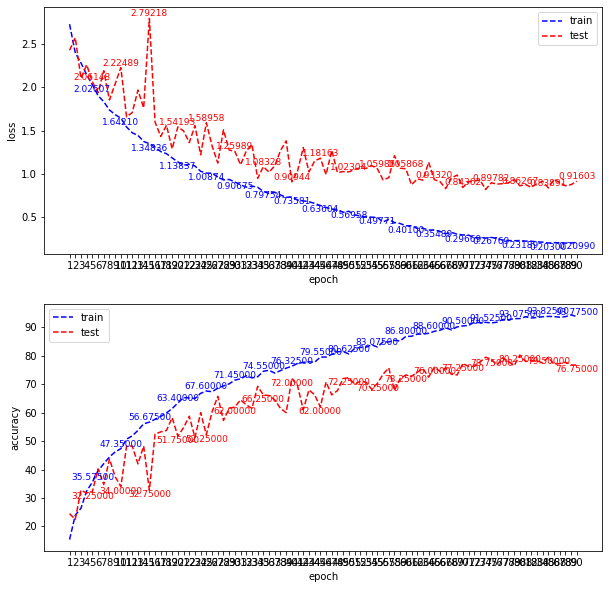

In [22]:
#visualize metric
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)

x = [i for i in range(1, epochs+1)]

ax1.plot(x, train_loss_list, 'b--')
ax1.plot(x, test_loss_list, 'r--')
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss')
ax1.legend(['train', 'test'])
ax1.set_xticks(x)
for i, v in enumerate(x):
    if (i+1)%5==0: ax1.text(v, train_loss_list[i], "{:0.5f}".format(train_loss_list[i]), fontsize = 9, color='blue', horizontalalignment='center', verticalalignment='top')
for i, v in enumerate(x):
    if (i+1)%5==0: ax1.text(v, test_loss_list[i], "{:0.5f}".format(test_loss_list[i]), fontsize = 9, color='red', horizontalalignment='center', verticalalignment='bottom')


ax2.plot(x, train_acc_list, 'b--')
ax2.plot(x, test_acc_list, 'r--')
ax2.set_xlabel('epoch')
ax2.set_ylabel('accuracy')
ax2.legend(['train', 'test'])
ax2.set_xticks(x)
for i, v in enumerate(x):
    if (i+1)%5==0: ax2.text(v, train_acc_list[i], "{:0.5f}".format(train_acc_list[i]), fontsize = 9, color='blue', horizontalalignment='center', verticalalignment='bottom')
for i, v in enumerate(x):
    if (i+1)%5==0: ax2.text(v, test_acc_list[i], "{:0.5f}".format(test_acc_list[i]), fontsize = 9, color='red', horizontalalignment='center', verticalalignment='top')

plt.show()